# ASTR 596: The Final

#### Three questions, each worth a third of your grade. (I'll make one 34 pts to get to an even 100). Each is designed to test an area where I think the class as a whole is less comfortable. They are sorted by my assesment of difficulty from easiest to hardest. 
#### i.e. the last is probably going to be non-trivial, because well I like Gaussian distributions of grades. 
#### That's OK because the points and grades don't matter!

#### Remember, you can work together, discuss problems and solutions, but you have to write up your own solution. I'd strongly suggest doing that, ideally with some divide and conquer strategy.

### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [1]:
# import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database
from sklearn.preprocessing import StandardScaler

GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

<Table length=20000>
   ug        gr        gi        gz    ... petroR50_i  deVAB_i  fracDev_i 
float64   float64   float64   float64  ...  float64    float64   float64  
-------- --------- --------- --------- ... ---------- --------- ----------
1.999718 0.9592915  1.370582  1.692535 ...   2.344662 0.8708095        1.0
 1.98884 0.9332962  1.361919  1.668918 ...   2.424093 0.9946066  0.8865207
1.020407  1.601521  2.396175  2.827263 ...   1.158836 0.6898293        1.0
 1.83742  1.211882  1.688545  1.989878 ...   2.795447 0.7493948        1.0
 4.55904  1.536175   2.29286  2.712597 ...    2.09032 0.5173162  0.8244159
4.532835  1.433081  2.251518  2.669952 ...   1.656738 0.6116931        1.0
     ...       ...       ...       ... ...        ...       ...        ...
1.623667 0.8156815    1.1889   1.46122 ...   1.977758 0.9590106  0.7323922
1.734089 0.4918652  0.749548 0.9232502 ...   4.231627   0.18726 0.07074465
 1.46096 0.6295528 0.9996338  1.211748 ...   3.736704 0.4292942  0.1576849
1.353111 0.6651058  1.052559   1.36347 ...   2.718136 0.4713597        0.0
2.167418  1.013105  1.446705  1.767793 ...   1.997034 0.7880045        1.0
2.773592  1.937073  2.858913   3.30508 ...   1.136474  0.616207        1.0
2.086315   1.71776   2.31568  2.704088 ...    1.32359 0.9704245        1.0

### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [2]:
SDSSgals.keys()

['ug', 'gr', 'gi', 'gz', 'petroRad_i', 'petroR50_i', 'deVAB_i', 'fracDev_i']

I first filter the data by removing, from each column, any row where the value is an outlier, defined as 15 times larger than the normalized median absolute deviation

In [3]:
# Filter data
from scipy.stats import median_abs_deviation
def nmad(column):
    '''Dey et al. 2022 definition of normalized median absolute deviation'''
    return 1.4826*median_abs_deviation(column)

# define a filter to clean and pre-process the data
def filter_data(table):
    filt = np.ones_like(table['ug']).astype(bool)
    for col_name in table.keys():
        filt &= (abs(table[col_name] - np.mean(table[col_name])) < 15.*nmad(table[col_name]))
    return table[filt]

In [4]:
filtered_SDSSgals = filter_data(SDSSgals)

In [5]:
len(SDSSgals) - len(filtered_SDSSgals)

70

This filtering removes 70 of the 20,000 galaxies

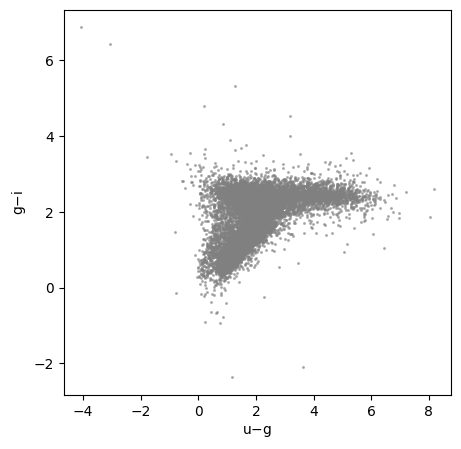

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(filtered_SDSSgals['ug'], filtered_SDSSgals['gi'], marker='.', color='grey', alpha=0.5,
           s=6)
plt.xlabel('u$-$g')
plt.ylabel('g$-$i')
plt.show()

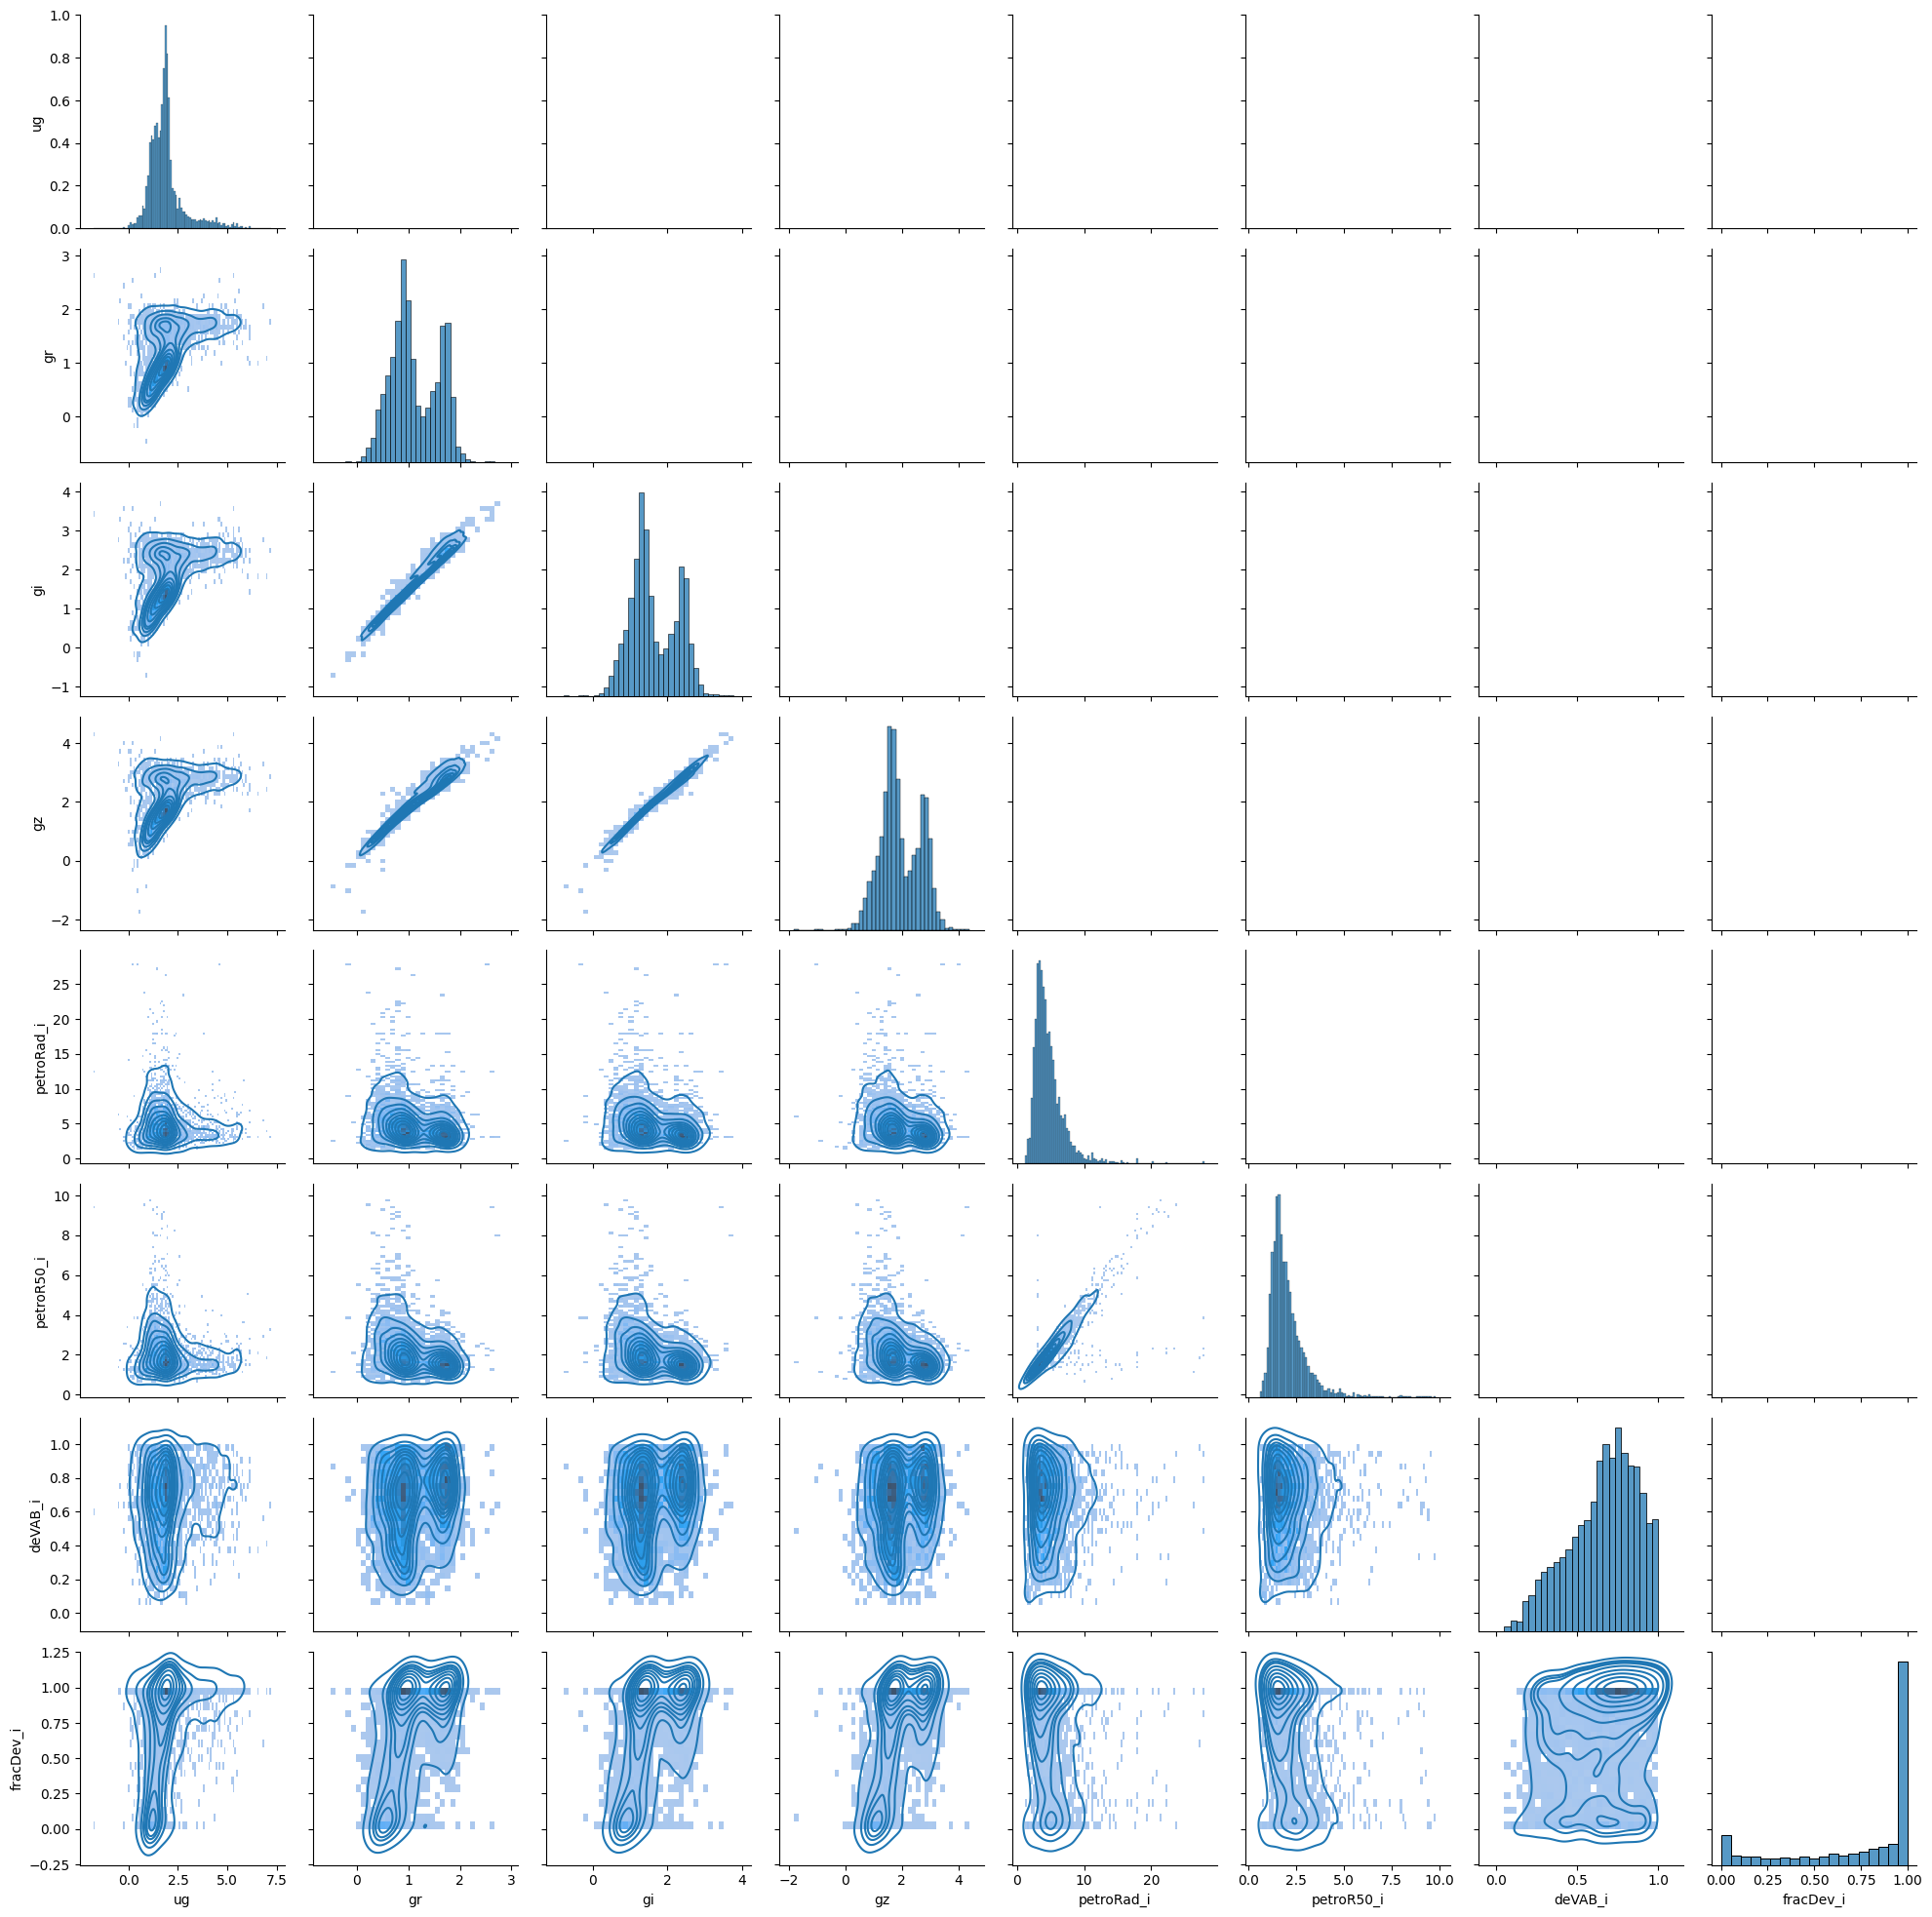

In [ ]:
g = sns.PairGrid(filtered_SDSSgals[::5].to_pandas(), diag_sharey=False)
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot)
g.map_lower(sns.histplot)

Above, I have plotted 20% of the data

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

I decide to use ```StandardScaler``` before using KMeans

In [ ]:
z = StandardScaler()
scaled_filtered_SDSSgals = z.fit_transform(filtered_SDSSgals.to_pandas())

In [9]:
scaled_df = pd.DataFrame(data=scaled_filtered_SDSSgals, columns=filtered_SDSSgals.to_pandas().columns)

I use the default "lloyd" algorithm since the other "elkan" algorithm is more memory intensive per scipy documentation. I increase the default maximum number of iterations and decrease the default tolerance

In [10]:
kmeans = KMeans(n_clusters=3, max_iter=1000, n_init='auto', tol=0.00005)
kmeans.fit(scaled_df)
labels = kmeans.labels_

In [11]:
# kmeans = KMeans(n_clusters=3, max_iter=1000, n_init='auto')
# kmeans.fit(filtered_SDSSgals.to_pandas())
# labels = kmeans.labels_

In [12]:
# # Try using PCA for dimensionality reduction:
# from sklearn.decomposition import PCA 
# # Compute PCA
# def compute_PCA(n_components=5):
#     nrows = len(filtered_SDSSgals)//10
#     ncols = len(filtered_SDSSgals.keys())
#     ind = np.random.randint(ncols, size=nrows)

#     # we're using only nrows to do the PCA and setting the mean as the first component
#     column_mean = filtered_SDSSgals[ind].to_pandas().mean(0)
#     pca = PCA(n_components - 1)

#     pca.fit(filtered_SDSSgals[ind].to_pandas())
#     # the PCA eigen"spectra" are:
#     pca_comp = np.vstack([column_mean,
#                           pca.components_])

#     # and the explained variance is:
#     evals = pca.explained_variance_ratio_

#     return pca_comp, evals, pca


# # YOU CAN CHANGE THIS 
# n_components = len(filtered_SDSSgals.keys())
# decompositions, evals, pca = compute_PCA(n_components)

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

First, I inverse the transform to get back to original data units

/var/folders/sk/4l4j4lgx4cjfp0hvc21tkqkm0000gn/T/ipykernel_93076/1878740888.py:7: RuntimeWarning: invalid value encountered in cast
  new_labels = np.empty(len(labels)).astype(np.int32)
/var/folders/sk/4l4j4lgx4cjfp0hvc21tkqkm0000gn/T/ipykernel_93076/1878740888.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['labels'] = new_labels[::5]#labels[::10]


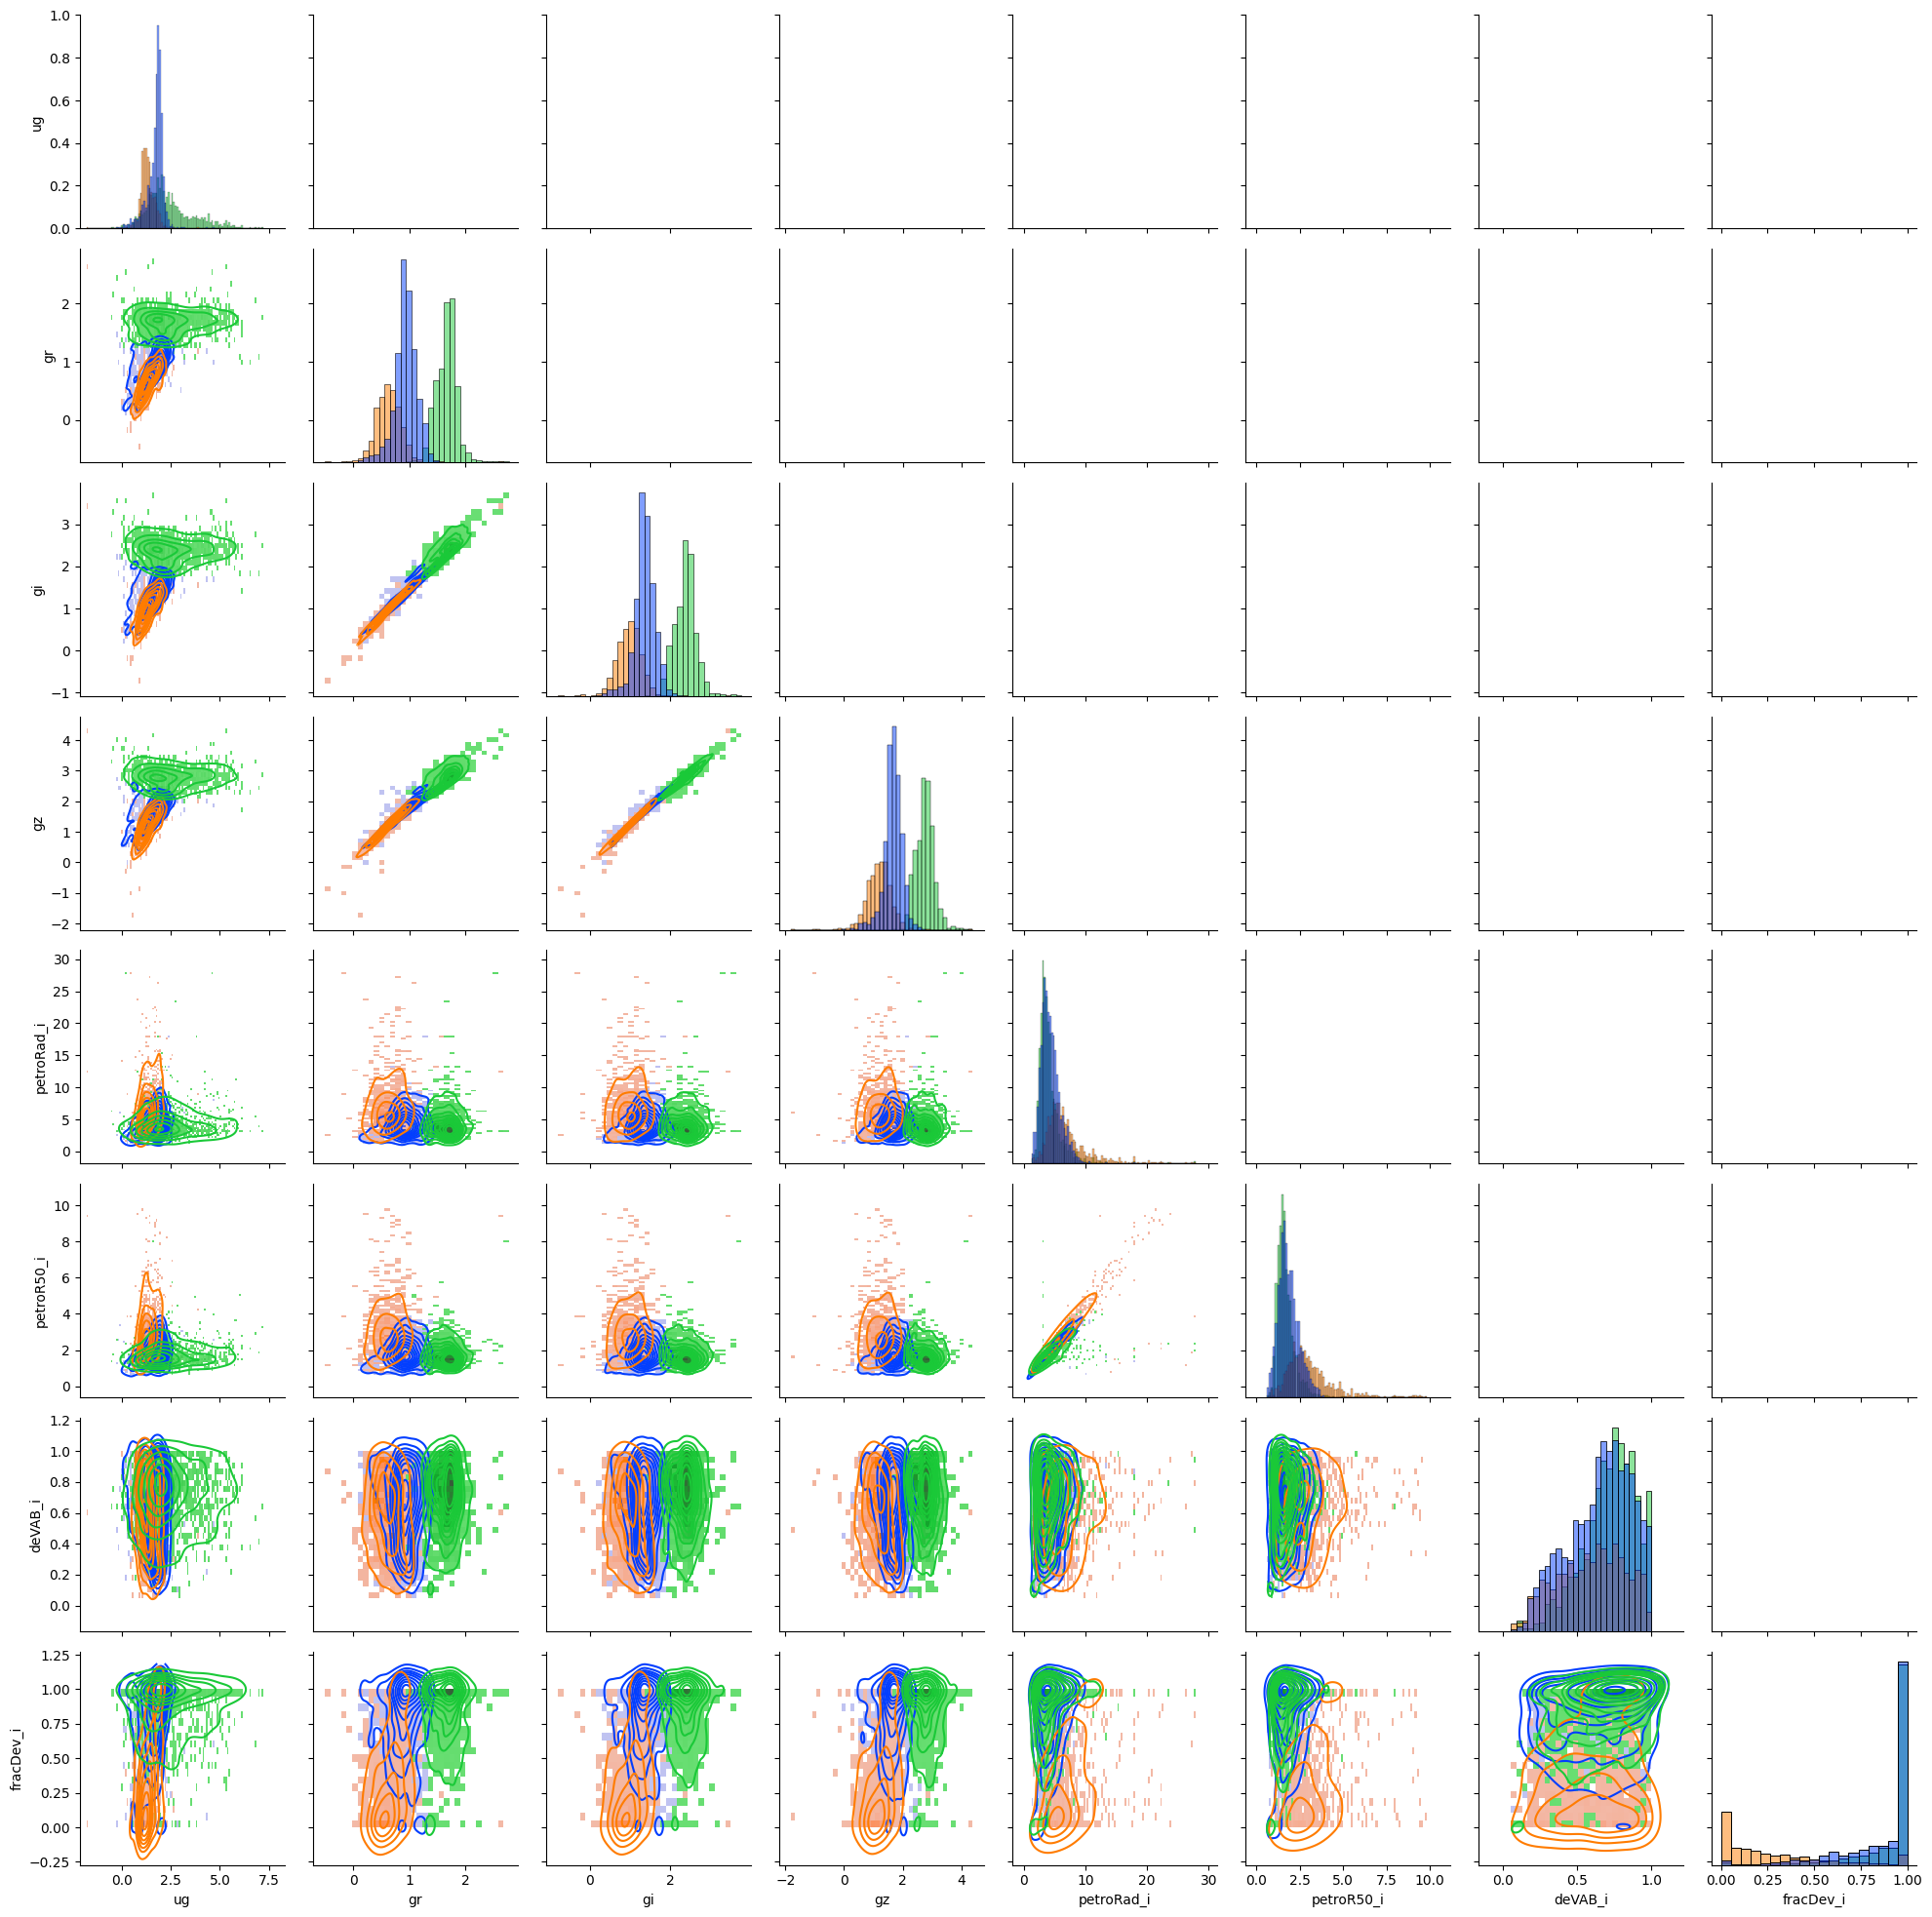

In [13]:
# sns.color_palette("tab10")

inverse_df = pd.DataFrame(data=z.inverse_transform(scaled_filtered_SDSSgals), 
                          columns=filtered_SDSSgals.to_pandas().columns)
new_df = inverse_df[::5]#scaled_df[::10]
#new_df = filtered_SDSSgals[::10].to_pandas()
new_labels = np.empty(len(labels)).astype(np.int32)
new_labels[labels == 0] = 2
new_labels[labels == 1] = 1
new_labels[labels == 2] = 0

new_df['labels'] = new_labels[::5]#labels[::10]
g = sns.PairGrid(new_df, hue='labels', diag_sharey=False, palette='bright')
g.map_diag(sns.histplot);
g.map_lower(sns.kdeplot);
g.map_lower(sns.histplot);

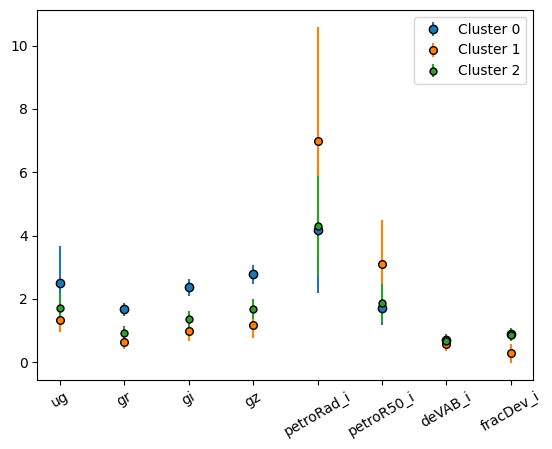

In [14]:
# print('Statistics of the entire sample:')
# print('Means: \n', filtered_SDSSgals.to_pandas().mean(0))
# print('++++++++++++++++++++')
# print('Standard deviations: \n', filtered_SDSSgals.to_pandas().std(0))
for l_ in range(3):
#     print('====================')
#     print('Cluster ', l_)
#     print('Means: \n', filtered_SDSSgals.to_pandas()[labels == l_].mean(0))
#     print('++++++++++++++++++++')
#     print('Standard deviations: \n', filtered_SDSSgals.to_pandas()[labels == l_].std(0))
    plt.errorbar(x=filtered_SDSSgals.keys(), 
                 y=filtered_SDSSgals.to_pandas()[labels == l_].mean(0), 
                 yerr=filtered_SDSSgals.to_pandas()[labels==l_].std(0),
                 label='Cluster '+str(l_),
                 fmt='o',
                mec='k',
                ms=6-0.5*l_)
plt.legend()
plt.xticks(rotation=30);

### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

### Examining the data:

In [15]:
# os.environ["OMP_NUM_THREADS"] = "1"

In [231]:
from astropy.table import Table, vstack
import numpy as np
l_curve = Table.read('asas_data.dat', comment='#', format='ascii',
                    names=['HJD',
                           'MAG_1',
                           'MAG_0',
                           'MAG_2',
                           'MAG_3', 
                           'MAG_4',
                           'MER_1',
                           'MER_0',
                           'MER_2',
                           'MER_3',
                           'MER_4',
                           'GRADE',
                           'FRAME'])

In [232]:
l_curve

<Table length=1294>
   HJD      MAG_1   MAG_0   MAG_2   MAG_3  ...  MER_3   MER_4  GRADE FRAME 
 float64   float64 float64 float64 float64 ... float64 float64  str1 int64 
---------- ------- ------- ------- ------- ... ------- ------- ----- ------
1869.74854   12.26  12.271  12.226  12.184 ...   0.031   0.037     A    292
1875.76359  11.497  11.548  11.495  11.507 ...   0.032   0.041     B   1221
1877.76186  12.222  12.248  12.222  12.246 ...   0.029   0.033     A   1539
1879.75361  12.023  12.049  12.048  12.054 ...   0.027   0.032     A   1851
1881.72783  11.561  11.549  11.553  11.542 ...   0.027   0.032     A   2154
1884.70932  11.637  11.669  11.661  11.676 ...   0.028   0.034     A   2295
       ...     ...     ...     ...     ... ...     ...     ...   ...    ...
 5131.8245   11.83  11.858  11.863  11.879 ...   0.046    0.05     B 331799
5136.84775  11.505  11.478  11.515  11.528 ...   0.067   0.077     D 332140
5154.83688  12.223  12.232  12.243  12.251 ...   0.047    0.05     B 333419
5158.74645    12.4   12.48  12.479  12.401 ...   0.062   0.067     D 333842
5162.78817  11.888  11.871   11.86  11.871 ...   0.048   0.052     B 334245
5165.75062   11.92  11.923  11.906  11.904 ...   0.048   0.055     A 334609
5168.73891  12.017  11.981  11.976  11.925 ...   0.055   0.062     D 334955

Insepcting the data file ```asas_data.dat```, the columns ```MAG_1``` and ```MAG_0``` have their positions transposed in the first dataset with respect to all of the others. In lieu of complicated pre-processing of the data, and since we have a wealth of data in the other apertured, we will use apertures 2, 3, and 4 going forward.

Trim the rows which are from the shorter datasets. These have reference RA and Dec which are not the same as the main data sets.

```dataset= 2 ; 2 F0624-56_068``` has length 10, ```dataset= 2 ; 3 F0624-56_068``` has length 16, ```dataset= 2 ; 4 F0624-56_068``` has length 22


The first two datasets have length 227 and 447 respectively, the last dataset has length 574

In [233]:
filt_l_curve = vstack([l_curve[:227+447],l_curve[-574:]])

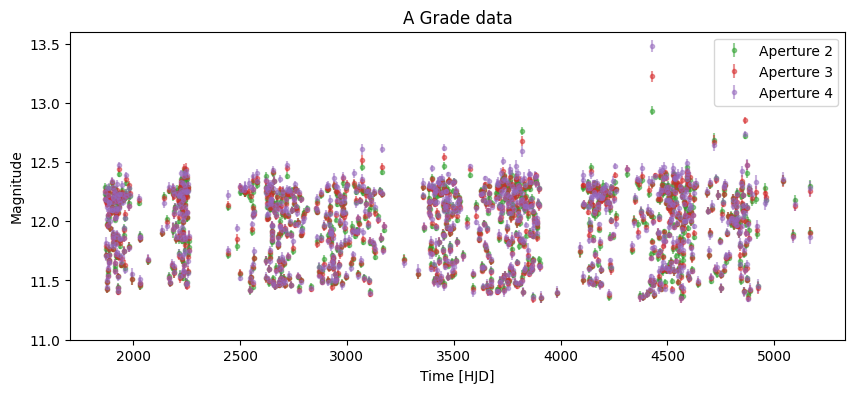

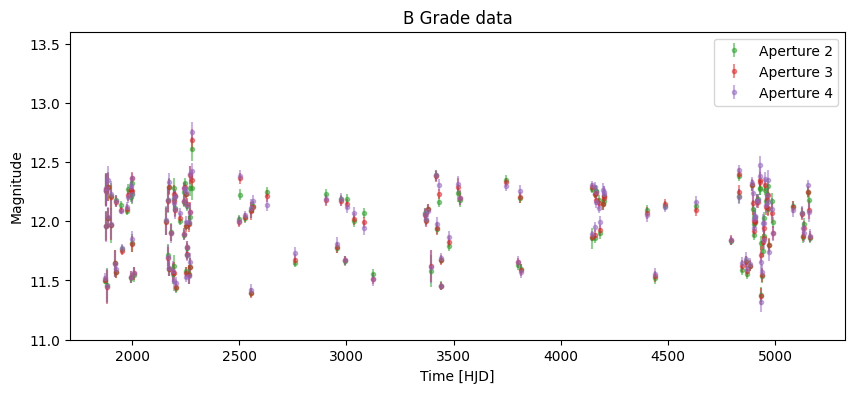

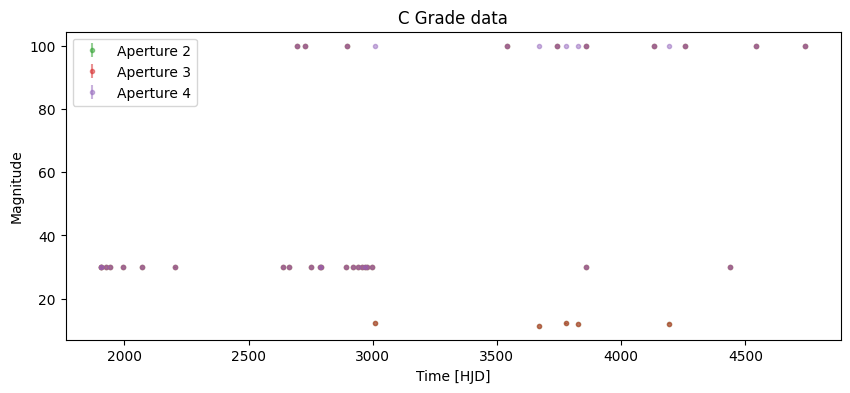

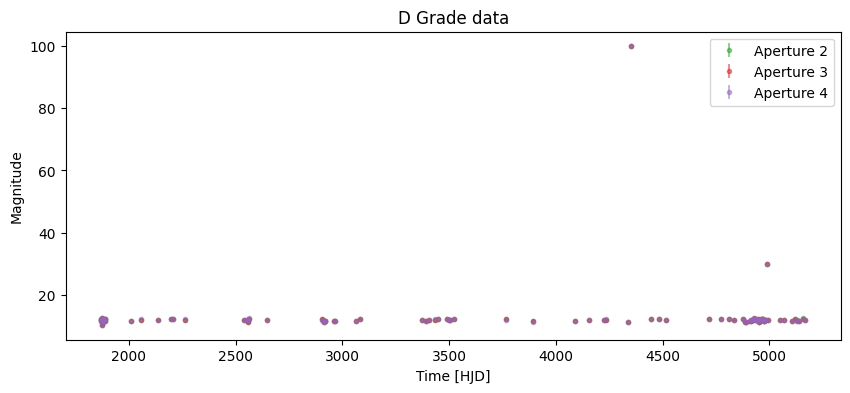

In [234]:
for filt_grade in np.unique(filt_l_curve['GRADE']):
    plt.figure(figsize=(10, 4))
    plt.title(filt_grade+' Grade data')
    plt.xlabel('Time [HJD]')
    plt.ylabel('Magnitude')
    filt = filt_l_curve['GRADE'] == filt_grade
    for aperture in ['2', '3', '4']:
        plt.errorbar(x=filt_l_curve['HJD'][filt], y=filt_l_curve['MAG_'+aperture][filt],
                    yerr=filt_l_curve['MER_'+aperture][filt], fmt='.', alpha=0.5,
                    c='C'+aperture, label='Aperture '+aperture)
    plt.legend()
    if filt_grade in ['A', 'B']:
        plt.ylim(11, 13.6)
    plt.show()

Because B grade data is the mean data, using A and B grade data together would almost be some double counting of data, or more specifically, biasing the data towards the mean. Since gaussian processes involve examining correlations in the data, this biasing could return misleading results.

We can also average across all apertures for each observation of A Grade, with our flux error calculated by summing in quadrature:

In [235]:
select_grade = filt_l_curve['GRADE'] == 'A'
t_avgs = filt_l_curve['HJD'][select_grade]
mag_avgs = np.average(np.array([filt_l_curve['MAG_'+i][select_grade] for i in ['0', 
                                                                             '1', 
                                                                             '2', 
                                                                             '3', 
                                                                             '4']]), axis=0)
err_avgs = np.sqrt(np.sum(np.array([filt_l_curve['MER_'+i][select_grade] for i in ['0', 
                                                                                   '1',
                                                                                   '2', 
                                                                                   '3', 
                                                                                   '4']])**2, axis=0))

Text(0, 0.5, 'Magnitude')

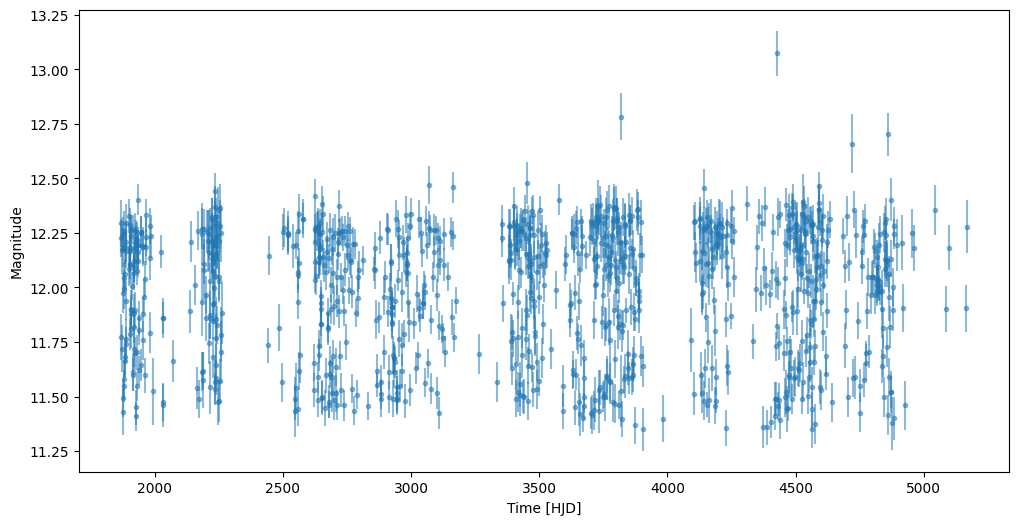

In [236]:
plt.figure(figsize=(12, 6))
plt.errorbar(x=t_avgs, y=mag_avgs, yerr=err_avgs, fmt='.', alpha=0.5)
plt.xlabel('Time [HJD]')
plt.ylabel('Magnitude')

We have some pretty clear outliers here, so we can filter by excluding data with magnitude outside of 2 times the normalized median absolute deviation from the mean of the data. 

In [237]:
filt2 = (mag_avgs - mag_avgs.mean()) < 2.*nmad(mag_avgs)

Text(0, 0.5, 'Magnitude')

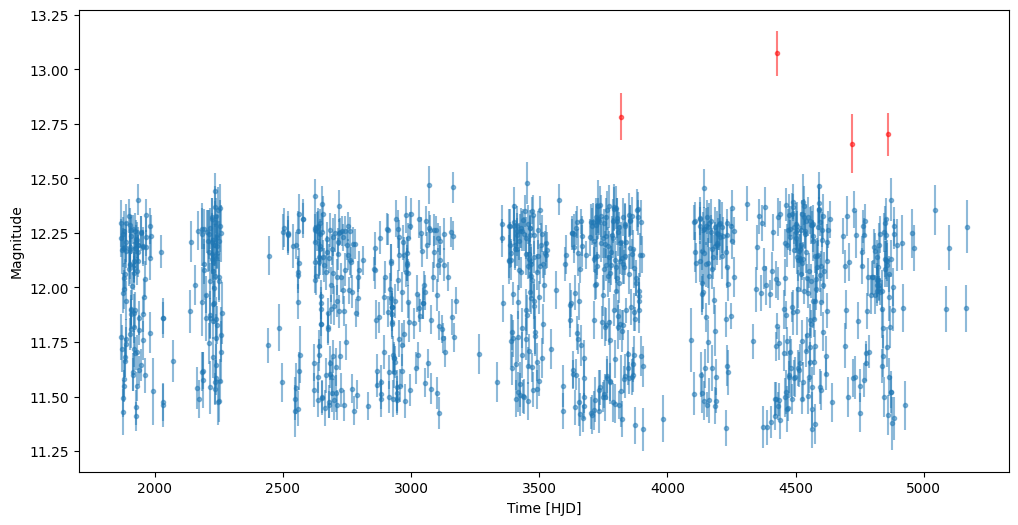

In [238]:
plt.figure(figsize=(12, 6))
plt.errorbar(x=t_avgs[filt2], y=mag_avgs[filt2], yerr=err_avgs[filt2], fmt='.', alpha=0.5)
plt.errorbar(x=t_avgs[~filt2], y=mag_avgs[~filt2], yerr=err_avgs[~filt2], fmt='.', alpha=0.5, c='r')

plt.xlabel('Time [HJD]')
plt.ylabel('Magnitude')


This filtering excludes 4 outliers, highlighted in red above.

In [239]:
t_avgs = t_avgs[filt2]
mag_avgs = mag_avgs[filt2]
err_avgs = err_avgs[filt2]

# Justify your choice here

```george``` implements the quasi-periodic kernel
\begin{equation}
k\left(\textbf{x}_i, \textbf{x}_j\right) = \exp\left(-\Gamma \sin^2 \left[\frac{\pi}{P} \left|x_i-x_j\right|\right]\right)
\end{equation}
as ```george.kernels.ExpSine2Kernel(gamma=None, log_period=None, bounds=None, ndim=1, axes=None)```



In [240]:
import george
def quasiPkern(A, gamma_, log_period_):
    # when multiplying by a constant, george takes the logarithm of the parameter by default.
    # we want the linear space version, so we'll exponentiate inside this function
#     return (np.e**A) * george.kernels.ExpSine2Kernel(gamma=gamma_, log_period=log_period_)
    return A * george.kernels.ExpSine2Kernel(gamma=gamma_, log_period=log_period_)

We also need to choose a mean function to specify a Gaussian process. Examining the light curve, there are not significant variations in the mean of the lightcurve at different epochs, so I choose to implement the mean function as a simple constant with time.

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

Text(0.5, 1.0, 'Lomb-Scargle Periodogram')

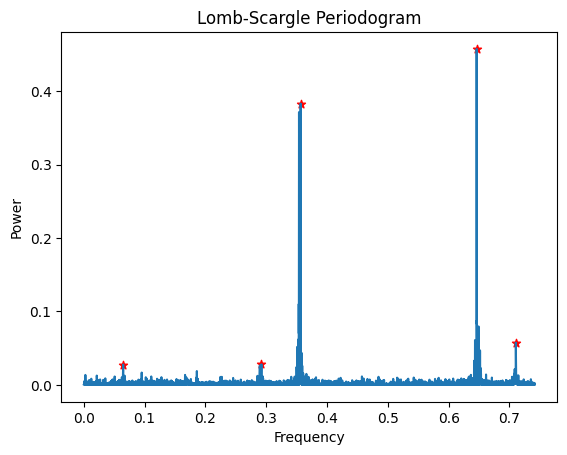

In [241]:
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks
frequency, power = LombScargle(t_avgs, mag_avgs).autopower()
peak_locations = find_peaks(power, prominence=0.02, distance=200)[0]
plt.plot(frequency, power)
plt.scatter(frequency[peak_locations], power[peak_locations], color='r', marker='*')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')

I use the parameters ```prominence = 0.02``` and ```distance=200``` in ```scipy.signal.find_peaks``` to find a coarse level view of the peaks in the Lomb-Scargle periodogram. The distance keyword limits identifying two strong peaks next to each other, which can be refined on when using MCMC, such as those at frequency $\sim$0.35.

Now that I have 5 candidate frequencies, I'll check to make sure none of them are in $1/2$ or $1/3$ resonance with the others. If this is the case, I'll trim the peak with longer period, and then finally keep the remaining peaks with the highest power.

In [242]:
candidate_periods = 1./frequency[peak_locations]
candidate_power = power[peak_locations]
period_info = Table((candidate_periods, candidate_power), names=['period','power']) 
period_info.sort(keys='power')
period_info[::-1]

<Table length=5>
      period              power        
                                       
     float64             float64       
------------------ --------------------
1.5478111497112814   0.4574980644318245
   2.8042804541975   0.3830497541579465
 1.407347304392368  0.05749097129567232
3.4233127712594755 0.028008580442147168
15.442587962529274  0.02770957397821806

In [243]:
test_periods = []
test_powers = []
period_info.sort(keys='period')
for i, period in enumerate(period_info['period']):
    if period in test_periods:
        pass
    test_period_2 = period/2.
    test_period_3 = period/3.
    print(period, test_period_2, test_period_3)
    
    delta_period_2 = np.abs(period_info['period'] - test_period_2)
    delta_period_3 = np.abs(period_info['period'] - test_period_3)
    
    if np.any(delta_period_2.value < 0.2) or np.any(delta_period_3.value < 0.2):
        print(f'Excluding period {period}')
        continue
    else:
        test_periods.append(period)
        test_powers.append(period_info['power'][i])
test_periods = np.array(test_periods)
test_powers = np.array(test_powers)

1.407347304392368 0.703673652196184 0.46911576813078937
1.5478111497112814 0.7739055748556407 0.5159370499037604
2.8042804541975 1.40214022709875 0.9347601513991667
Excluding period 2.8042804541975
3.4233127712594755 1.7116563856297378 1.1411042570864918
Excluding period 3.4233127712594755
15.442587962529274 7.721293981264637 5.147529320843091


In [244]:
test_periods

array([ 1.4073473 ,  1.54781115, 15.44258796])

(0.0, 0.4674980644318245)

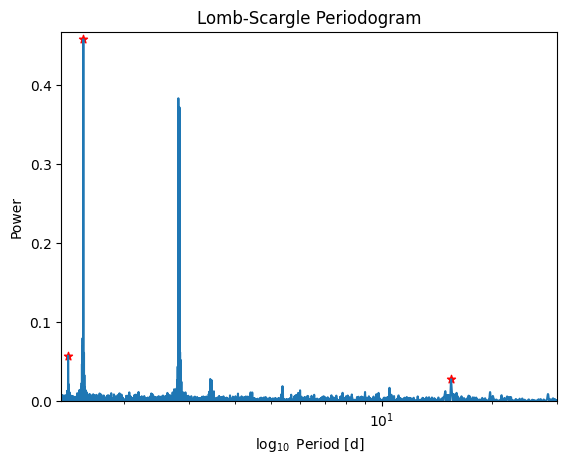

In [245]:
plt.semilogx(1./frequency, power)
plt.scatter(test_periods, test_powers, color='r', marker='*')
plt.xlabel(r'$\log_{10}$ Period [d]')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.xlim(np.min(1./frequency), 30)
plt.ylim(0, np.max(power)+0.01)

Two of our identified peaks had some resonance, so now we have 3 candidate periods to initialize our walkers.

### N.B. I think this was probably fine, but in testing, I am trying to overhaul some of the assumptions I made. I will ignore the above and instead consider the periods with the highest power, which just changes one of them.

Now, the periods with the highest power are:

In [289]:
period_info[:3]

<Table length=3>
      period              power       
                                      
     float64             float64      
------------------ -------------------
 1.407347304392368 0.05749097129567232
1.5478111497112814  0.4574980644318245
   2.8042804541975  0.3830497541579465

In [292]:
test_periods = period_info[:3]['period'].data

In [294]:
import emcee
import corner

For the other parameters, we can initialize the mean function using the mean of all of the magnitudes in the light curve.

Inspecting the phase-folded lightcurves for the initial guesses of period:

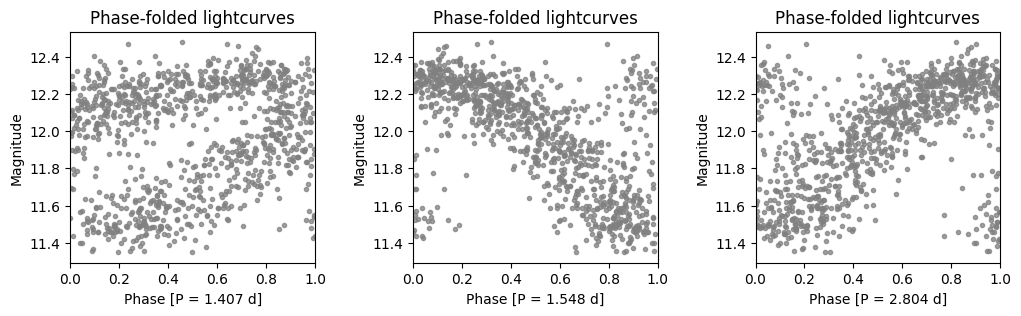

In [295]:
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.1)
for i, t_p in enumerate(test_periods):
    plt.subplot(1,3,i+1)
    plt.scatter(((t_avgs - t_avgs.min()) % t_p)/t_p, mag_avgs, marker='.', color='grey', alpha=0.75)
    plt.ylabel('Magnitude')
    plt.xlabel('Phase [P = {:.3f} d]'.format(t_p))
    plt.title('Phase-folded lightcurves')
    plt.xlim(0,1)
plt.show()

In [296]:
@np.vectorize
def k_test(lag, a, gamma, p):
    return a*np.exp(-gamma*np.sin(np.pi*abs(lag)/p)**2)
#     return a*np.exp(-gamma*np.sin(np.pi*abs(lag)/p)**2 - lag**2/lambda_)

Text(0, 0.5, 'Quasi-periodic kernel k(t$_i$, t$_j$)')

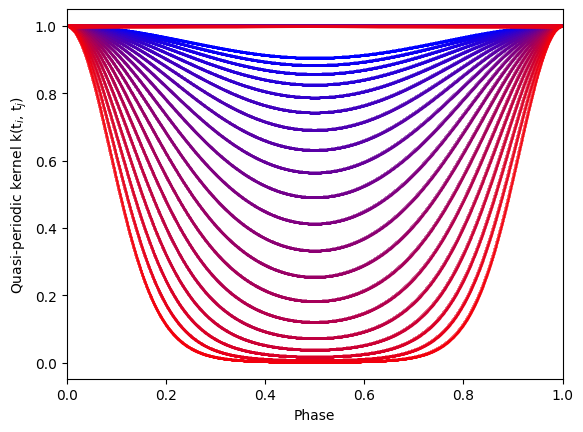

In [297]:
test_P = 2.
tgrid = np.linspace(0, test_P*50, 50*100)
for i, g in enumerate(np.linspace(-1, 0.8, 20)):
    plt.plot((tgrid % test_P)/test_P, k_test(tgrid, 1, 10**g, test_P), 
                marker='.',
                 markersize=1,
                color=(i/20, 0, 1-(i/20)),
                alpha=0.5)

plt.xlim(0,1)
plt.xlabel('Phase')
plt.ylabel(r'Quasi-periodic kernel k(t$_i$, t$_j$)')

The panel above shows the effect that $\Gamma$ has on the chosen kernel, with value increasing from $10^{-1}$ to $10^{0.8}$ from blue to red.

Define the mean model:

In [298]:
from george.modeling import Model

class GenericConstantMeanModel(Model):
    parameter_names = ("m")
    def get_value(self, t):
        return np.repeat(self.m, len(t))

Define the GP model object

In [310]:
# gp = george.GP(mean=GenericConstantMeanModel(np.mean(mag_avgs)),
#               kernel=quasiPkern(np.std(mag_avgs), 50, np.log(test_periods[1])))

gp = george.GP(mean=GenericConstantMeanModel(np.mean(mag_avgs)),
              kernel=quasiPkern(np.std(mag_avgs), 5, np.log(test_periods[1])))

In [311]:
gp.get_parameter_dict()

OrderedDict([('mean:m', 11.97541554192229),
             ('kernel:k1:log_constant', -1.2372217528682479),
             ('kernel:k2:gamma', 5.0),
             ('kernel:k2:log_period', 0.4368417714148385)])

In [312]:
gp.compute(t_avgs[::skip_n], err_avgs[::skip_n])

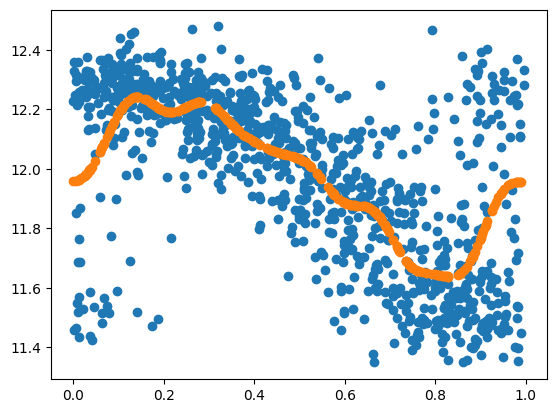

In [313]:
cand_period = test_periods[1]
plt.scatter(((t_avgs - np.min(t_avgs)) % cand_period)/cand_period, 
            mag_avgs)
plt.scatter(((t_avgs[::skip_n] - np.min(t_avgs)) % cand_period)/cand_period,
           gp.predict(mag_avgs[::skip_n], t_avgs[::skip_n], return_cov=False))

It takes a long time to compute the gp on the whole data set. We can condition it on just a fraction of the data. Here's what the data looks like including only every 3rd data point:

Text(0, 0.5, 'Magnitude')

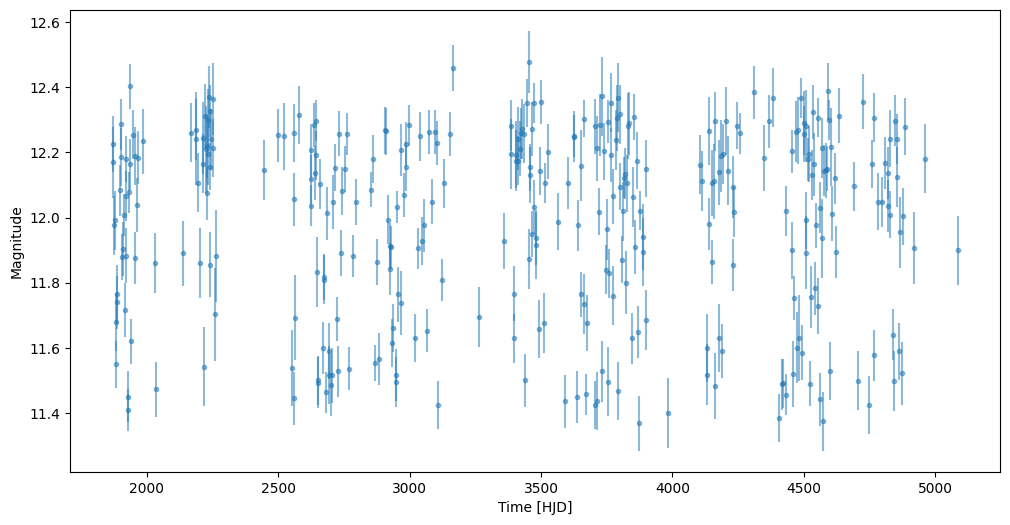

In [314]:
plt.figure(figsize=(12, 6))
plt.errorbar(x=t_avgs[::3], y=mag_avgs[::3], yerr=err_avgs[::3], fmt='.', alpha=0.5)

plt.xlabel('Time [HJD]')
plt.ylabel('Magnitude')

Use every 3rd data point

In [315]:
skip_n = 3#5
gp.compute(t_avgs[::skip_n], err_avgs[::skip_n])

Text(0.5, 0, '$\\Delta$ t [$\\log$ days]')

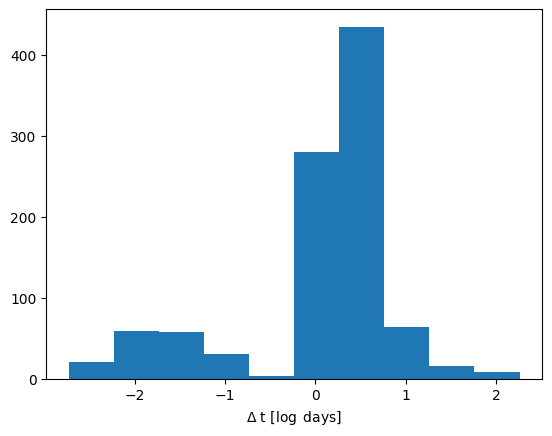

In [316]:
t_sorted = t_avgs[np.argsort(t_avgs)]
delta_t = (t_sorted[1:] - t_sorted[:-1])
plt.hist(np.log10(delta_t[delta_t > 0]))
plt.xlabel('$\Delta$ t [$\log$ days]')

In [317]:
t_avgs.max() - t_avgs.min()

3296.99253

I motivate my priors in the following ways: 

### m:
```m``` is the constant value of the mean function. A good guess for what this value is is, well, the mean of all of the measured magnitudes. The measured magnitudes span a range of $\sim 1.7$ mag, so we can take bounds of $\pm 2$ about the true mean of the data, to be generous. Within this bound, the prior is a gaussian centered on the true mean with width equal to the standard deviation of the data.

### A:
```A``` scales the quasiperiodic kernel. It can be thought of as the amplitude of the quasiperiodic signal. First, we'll impose a lower bound that it has to be greater than 0 (sensible, since we know there is variablility in the light curve!) and we'll let the prior on A be a gaussian centered on the standard deviation of the observations ($\sim$ 0.3 mag), with a generous width of twice that.

### P:
In the panel above, I show the distribution of the difference in times between successive observations in the data. The range of data is $\sim$ 3300 days. Ultimately since the kernel we use cares about lags relative to the chosen period, rather than absolute positions in the sequence, we may be able to probe periodicities smaller than what is indicated by the histogram above, but at a certain point, we run into the wall of what can reasonably be detected with our sampling, as well as the periods over which stars are variable at these magnitudes. Again, to be generous, we'll set a lower bound of $10^{0}$ days, and an upper bound of $10^{1.5}$ days, a bit longer than the longest classical Cepheid periods. Since we did a coarse pass on estimating P using the Lomb-Scargle periodogram and found good guesses from 1 to 15 days, we'll keep a uniform prior.

### $\Gamma$:
A tricky parameter to guess because it describes how "quasi-" our quasi-periodic signal is. From some tuning that I did in homework 6, as well as looking at a few panels above, I'll set the lower bound to $10^0$ and the upper bound to $10^3$, uniform prior.

In [318]:
np.log(test_periods)

array([0.34170659, 0.43684177, 1.03114698])

In [333]:
m_mean_guess = np.mean(mag_avgs)
m_width_guess = np.std(mag_avgs)
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
def log_prior(theta): 
    m, A, gamma, log_P = theta
#     if (A < 0):
#         return -np.inf
    if (gamma < 0.5) or (gamma > 100):
        return -np.inf
    if (m < m_mean_guess - 2) or (m > m_mean_guess + 2):
        return -np.inf
    if (log_P < -1.) or (log_P > 1.5):
        return -np.inf
    
    logp_m = np.log(gaussian(m, m_mean_guess, m_width_guess))
#     logp_A = np.log(gaussian(A, m_width_guess, 2*m_width_guess))
    
    logp = logp_m
    return logp

In [334]:
def lnprob(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(mag_avgs[::skip_n], quiet=True) + log_prior(p)

In [335]:
import scipy.optimize as so
# Define reduced chi2 so that we can use scipy.optimize.minimize
def chisq(p, *args):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(mag_avgs[::skip_n], quiet=True)
#     m_obs, t_obs, e_obs = args
#     model_flux = gp.predict(m_obs, t_obs, return_cov=False)
#     chisq = np.sum(((m_obs - model_flux)**2.)/(e_obs**2.))/(len(t_obs) - 4)
#     return chisq 

bounds = [(m_mean_guess - 2, m_mean_guess + 2),
          (-5, m_mean_guess+2),
          (0.5, 100),
          (-1., 1.5)]


guess = (m_mean_guess,
         np.std(mag_avgs),
         2,
         0.34170659)

res = so.minimize(chisq, guess, args=(mag_avgs[::skip_n], 
                                      t_avgs[::skip_n], 
                                      err_avgs[::skip_n]), 
                          bounds=bounds)
print(res)

      fun: 1411.0451985971604
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00384261,  3.83877252, -1.12347607,  1.19594006])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 27
     njev: 44
   status: 0
  success: True
        x: array([11.97671462,  1.29072992,  5.4576797 ,  0.34174792])


In [336]:
res.x

array([11.97671462,  1.29072992,  5.4576797 ,  0.34174792])

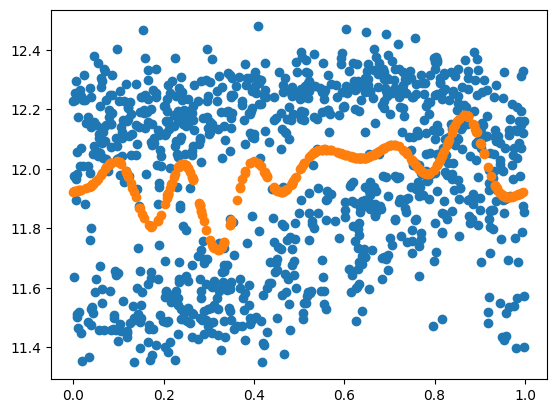

In [337]:
cand_period = np.e**res.x[3]
plt.scatter(((t_avgs - np.min(t_avgs)) % cand_period)/cand_period, 
            mag_avgs)
plt.scatter(((t_avgs[::skip_n] - np.min(t_avgs)) % cand_period)/cand_period,
           gp.predict(mag_avgs[::skip_n], t_avgs[::skip_n], return_cov=False))

Initializing parameters:

In [338]:
ndim, nwalkers = 4, 99
p0 = np.empty((nwalkers, ndim))
for i in range(3):
    initial = [res.x[0], res.x[1], res.x[2], np.log(test_periods[i])]
    p0[33*i:33*(i+1)] = initial + 5e-2 * np.random.randn(nwalkers//3, ndim)

In [339]:
# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
#     sampler.run_mcmc(p0, 100, progress=True)



sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
nburn = 500
nsamp = 1000
_ = sampler.run_mcmc(p0, nburn+nsamp, progress=True)

100%|███████████████████████████████████████| 1500/1500 [06:28<00:00,  3.86it/s]


In [340]:
samples = sampler.get_chain(flat=True)

In [343]:
labels = ['m', 'A', r'$\Gamma$', r'$\log$P']

In [344]:
samples_not_flat = sampler.get_chain()

In [345]:
# plt.figure(figsize=(8, 8))
# for it, label_name in enumerate(labels):
#     plt.subplot(2, 2, it+1)
#     plt.subplots_adjust(hspace=0.3, wspace=0.3)
#     plt.plot(samples[::10, it], color='grey', alpha=0.3, marker='.', markersize=1, linewidth=0.1)
# #     for w in range(99):
# #         plt.plot(samples_not_flat[::10, w,  it], alpha=0.3, color='grey', marker='.')
#     plt.title(label_name)
# plt.show()

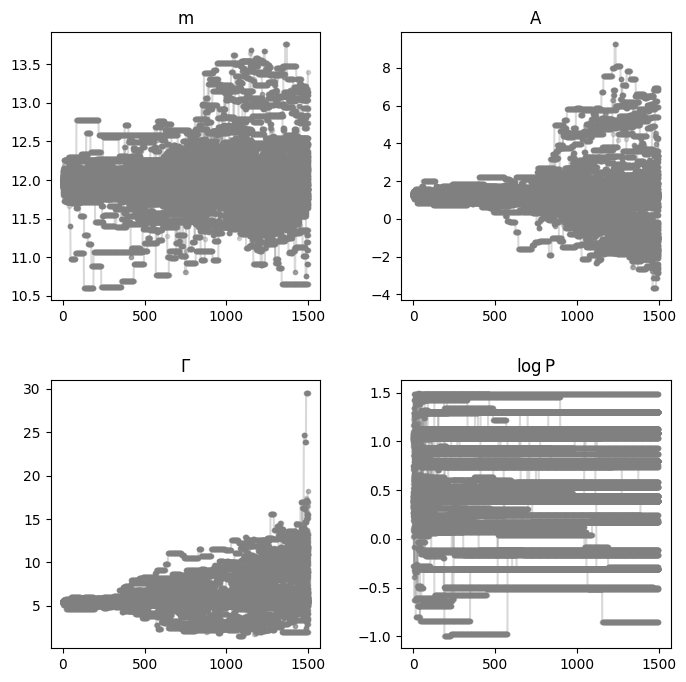

In [346]:
plt.figure(figsize=(8, 8))
for it, label_name in enumerate(labels):
    plt.subplot(2, 2, it+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
#     plt.plot(samples[:, it], color='grey', alpha=0.3, marker='.', markersize=1, linewidth=0.1)
    for w in range(99):
        plt.plot(samples_not_flat[:, w,  it], alpha=0.3, color='grey', marker='.')
    plt.title(label_name)
plt.show()

Inspecting the trace plots, they're bad but burn-in isn't the problem

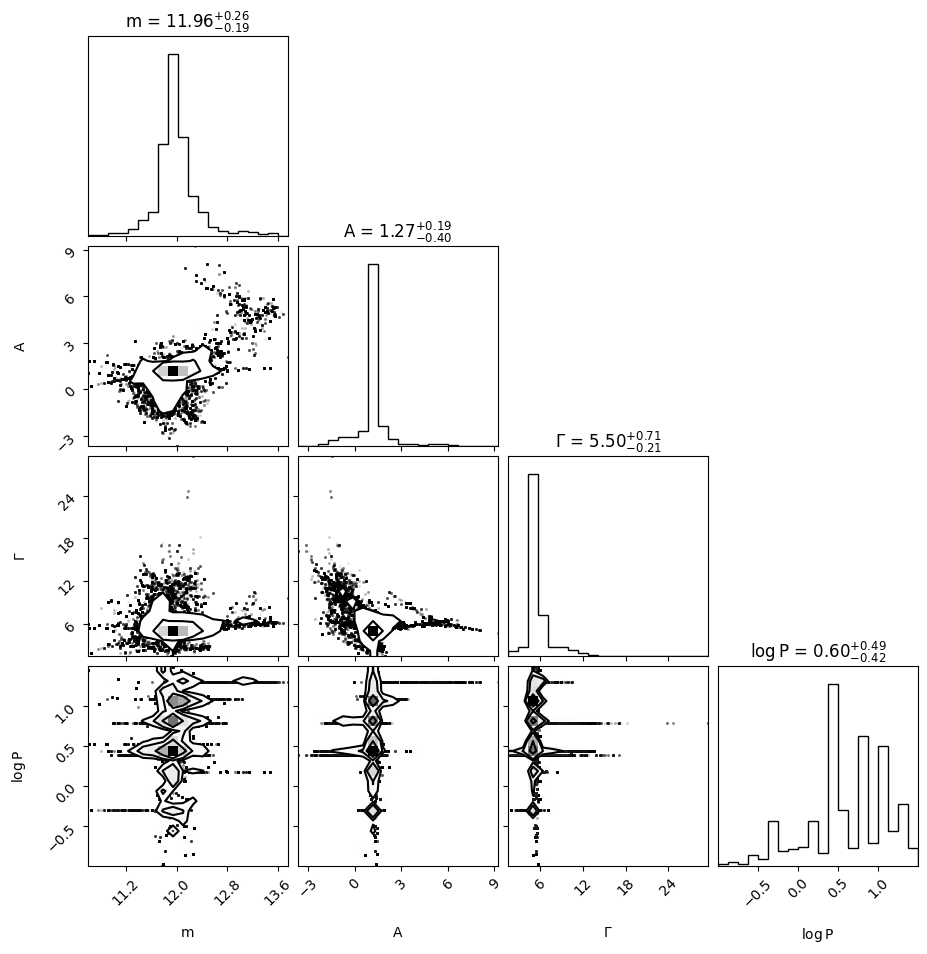

In [347]:
corner.corner(samples, labels=labels,
             show_titles=True);

### Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior.

Text(0, 0.5, 'log Posterior')

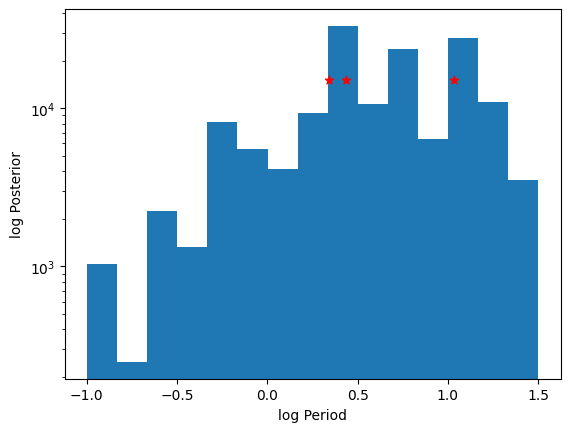

In [348]:
plt.hist(samples[:, 3], log=True, bins=15)
plt.scatter(np.log(test_periods), np.ones_like(test_periods)*1.5e4, marker='*', color='r')
plt.xlabel('log Period')
plt.ylabel('log Posterior')

Marginalizing over all of the other parameters, it's a bit of a mess. We'll say the log period is probably somewhere between 0.1 and 0.8 in log units

In [349]:
median_p0 = [np.median(samples[:,q]) for q in range(samples.shape[1])]
median_p0[3] = 0.45

In [350]:
ndim, nwalkers = 4, 99
median_p0 += 5e-2 * np.random.randn(nwalkers, ndim)

I adjust the priors slightly, changing the bounds of the prior on log period to log P $\in [0, 1.5]$ to restrict to our selected period
<!-- , and $\Gamma \in [20, 70]$, and A$\in [0, 3]$ -->

In [353]:
def log_prior2(theta): 
    m, A, gamma, log_P = theta
    if (gamma < 0.5) or (gamma > 100):
        return -np.inf
    if (m < m_mean_guess - 2) or (m > m_mean_guess + 2):
        return -np.inf
    if (log_P < -0.5) or (log_P > 0.6):
        return -np.inf
    
    logp_m = np.log(gaussian(m, m_mean_guess, m_width_guess))    
    logp = logp_m
    return logp

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(mag_avgs[::skip_n], quiet=True) + log_prior2(p)

In [354]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)
nsamp = 1000
_ = sampler2.run_mcmc(median_p0, nsamp, progress=True)

100%|███████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 


In [355]:
samples2 = sampler2.get_chain(flat=True)

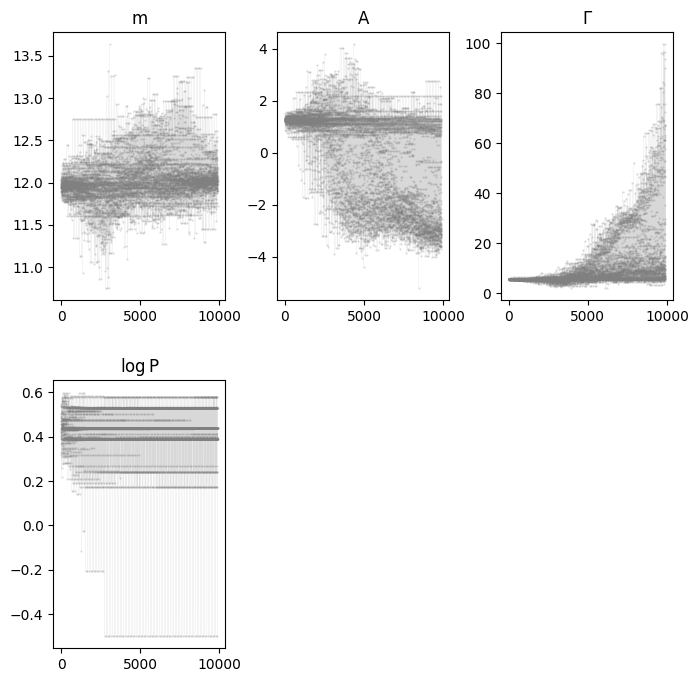

In [356]:
plt.figure(figsize=(8, 8))
for it, label_name in enumerate(labels):
    plt.subplot(2, 3, it+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.plot(samples2[::10, it], color='grey', alpha=0.3, marker='.', markersize=1, linewidth=0.1)
    plt.title(label_name)
plt.show()

Again, bad chains

In [357]:
sampler2.get_chain(flat=True).shape

(99000, 4)

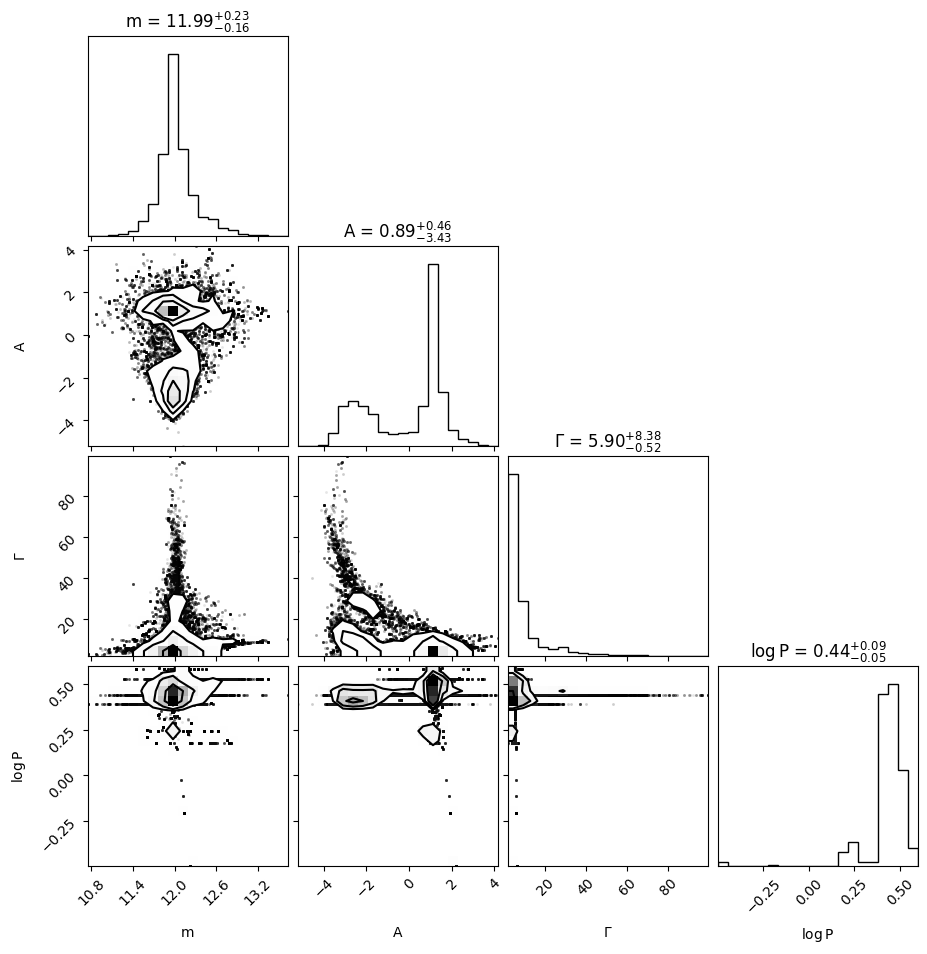

In [358]:
corner.corner(sampler2.get_chain(flat=True), labels=labels,
             show_titles=True);

We still have a little bit of wandering of the walkers, but for the most part our parameters are about as constrained as I can get them to be.

Folded lightcurve

In [359]:
stats = np.percentile(sampler2.get_chain(flat=True), [16, 50, 84], axis=0)

In [360]:
print('median period = ', np.e**stats[1][3], 'days')

median period =  1.5477104088002824 days


In [361]:
print(t_avgs.min(), t_avgs.max())

1869.74854 5166.74107


In [362]:
tgrid = np.linspace(1800, 5200, len(t_avgs[::skip_n]))
gp.set_parameter_vector(stats[1])
yfull, cov = gp.predict(mag_avgs[::skip_n], tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))

Text(0.5, 1.0, 'Phase folded light curve + median model')

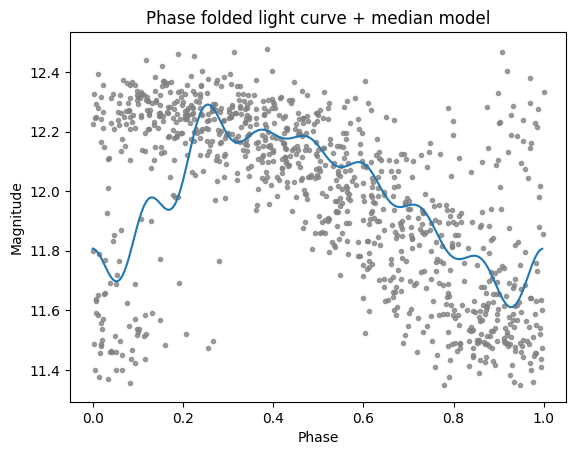

In [363]:
median_period = np.e**(stats[1][3])
plt.scatter(((t_avgs - t_avgs.min()) % median_period)/median_period, 
            mag_avgs,
            marker='.', color='grey', alpha=0.75)
t_mod = ((tgrid - tgrid.min()) % median_period)/median_period
t_sorted = np.argsort(t_mod)
plt.plot(t_mod[t_sorted], yfull[t_sorted])
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.title('Phase folded light curve + median model')

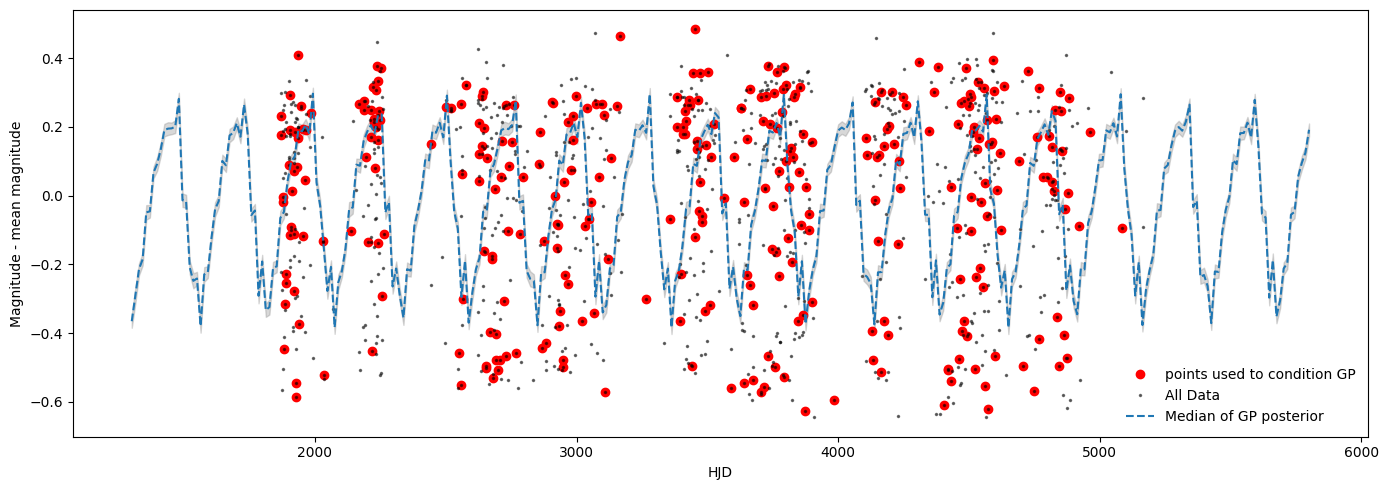

In [364]:
fig4, ax4 = plt.subplots(1,figsize=(14,5))
tgrid = np.linspace(1300, 5800, len(t_avgs[::skip_n]))
stats = np.percentile(sampler2.get_chain(flat=True), [50, 16, 84], axis=0)
res = stats[0]
gp.set_parameter_vector(res)

y = mag_avgs[::skip_n]
t = t_avgs[::skip_n]
yfull, cov = gp.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))

tall = t_avgs
yres = y - gp.mean.get_value(t)
yall = mag_avgs-gp.mean.get_value(tall)
ypred = yfull-gp.mean.get_value(tgrid)


ax4.plot(t, yres, 'ro', label='points used to condition GP')
ax4.plot(tall, yall, 'k.', ms=3, alpha=0.5, label='All Data')
ax4.plot(tgrid, ypred, color='C0',linestyle='--', label='Median of GP posterior')
ax4.fill_between(tgrid, ypred-err, ypred+err, color='grey', alpha=0.3)

ax4.set_xlabel('HJD')
ax4.set_ylabel('Magnitude - mean magnitude')
ax4.legend(frameon=False)
    
fig4.tight_layout()



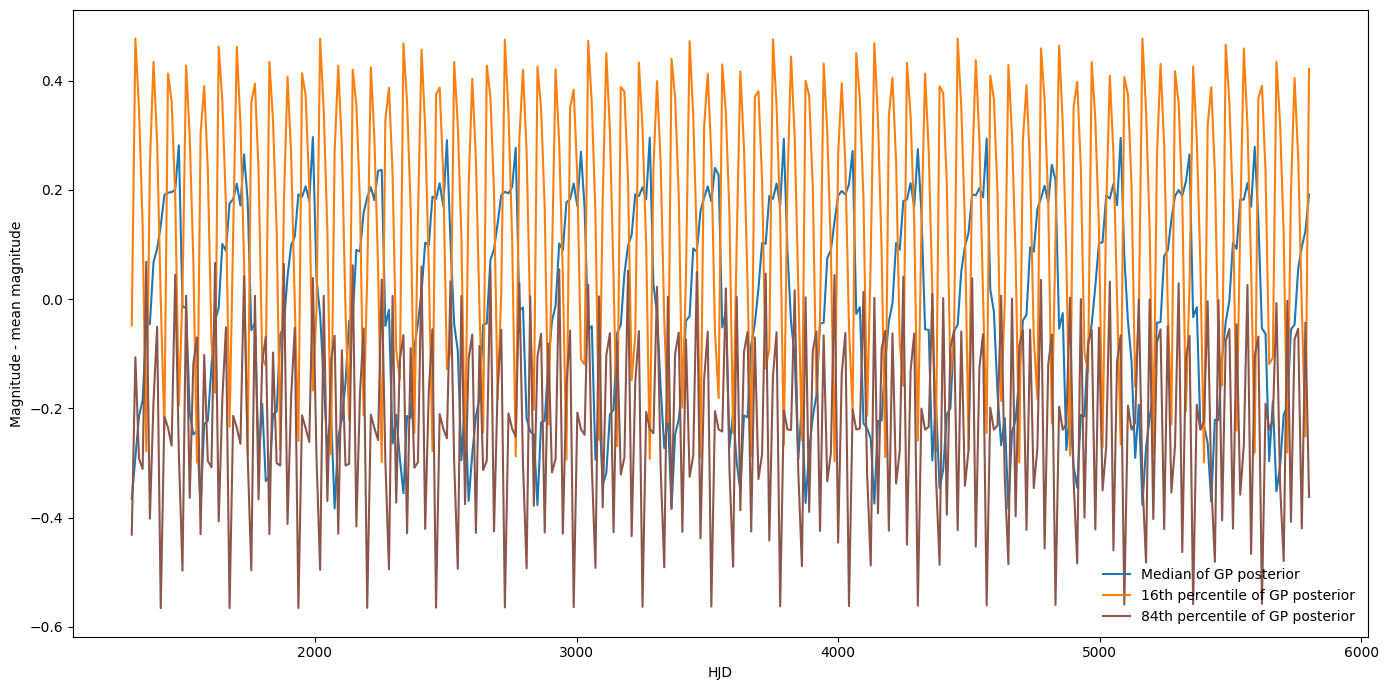

In [365]:
fig4, ax4 = plt.subplots(1,figsize=(14,7))
tgrid = np.linspace(1300, 5800, len(t_avgs[::skip_n]))
stats = np.percentile(sampler2.get_chain(flat=True), [50, 16, 84], axis=0)
res = stats[0]
gp.set_parameter_vector(res)

y = mag_avgs[::skip_n]
t = t_avgs[::skip_n]
yfull, cov = gp.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))

tall = t_avgs
yres = y - gp.mean.get_value(t)
yall = mag_avgs-gp.mean.get_value(tall)
ypred = yfull-gp.mean.get_value(tgrid)


# ax4.plot(t, yres, 'ro', label='points used to condition GP')
# ax4.plot(tall, yall, 'k.', ms=3, alpha=0.5, label='All Data')
ax4.plot(tgrid, ypred, color='C0',linestyle='-', label='Median of GP posterior')
# ax4.fill_between(tgrid, ypred-err, ypred+err, color='grey', alpha=0.3)

gp.set_parameter_vector(stats[1])
yfull, cov = gp.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))
ypred = yfull-gp.mean.get_value(tgrid)
ax4.plot(tgrid, ypred, color='C1',linestyle='-', label='16th percentile of GP posterior')

gp.set_parameter_vector(stats[2])
yfull, cov = gp.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))
ypred = yfull-gp.mean.get_value(tgrid)
ax4.plot(tgrid, ypred, color='C5',linestyle='-', label='84th percentile of GP posterior')


ax4.set_xlabel('HJD')
ax4.set_ylabel('Magnitude - mean magnitude')
ax4.legend(frameon=False)
    
fig4.tight_layout()



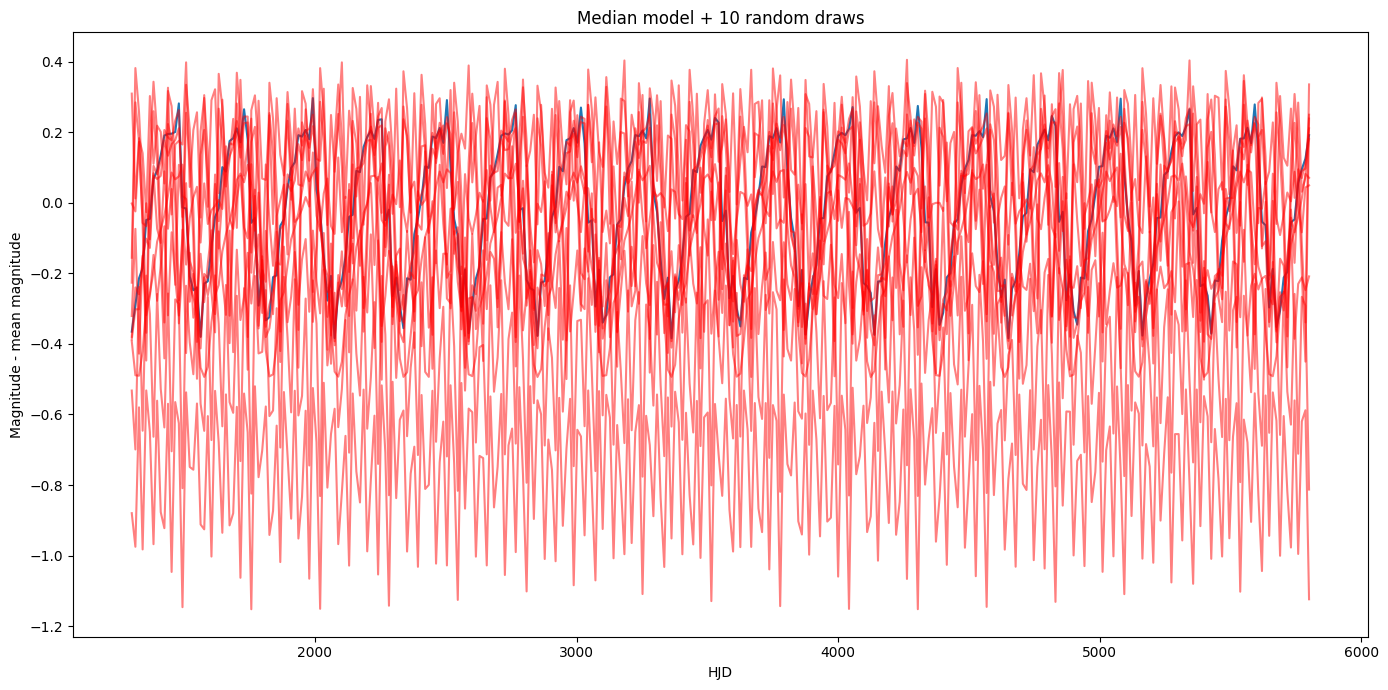

In [366]:
fig4, ax4 = plt.subplots(1,figsize=(14,7))
tgrid = np.linspace(1300, 5800, len(t_avgs[::skip_n]))
stats = np.percentile(sampler2.get_chain(flat=True), [50, 16, 84], axis=0)
res = stats[0]
gp.set_parameter_vector(res)

y = mag_avgs[::skip_n]
t = t_avgs[::skip_n]
yfull, cov = gp.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))

tall = t_avgs
yres = y - gp.mean.get_value(t)
yall = mag_avgs-gp.mean.get_value(tall)
ypred = yfull-gp.mean.get_value(tgrid)


# ax4.plot(t, yres, 'ro', label='points used to condition GP')
# ax4.plot(tall, yall, 'k.', ms=3, alpha=0.5, label='All Data')
ax4.plot(tgrid, ypred, color='C0',linestyle='-')
# ax4.fill_between(tgrid, ypred-err, ypred+err, color='grey', alpha=0.3)

for r_n in np.random.randint(len(sampler2.get_chain(flat=True)), size=10):
    


    gp.set_parameter_vector(sampler2.get_chain(flat=True)[r_n])
    yfull, cov = gp.predict(y, tgrid, return_cov=True)
    err = np.sqrt(np.diag(cov))
    ypred = yfull-gp.mean.get_value(tgrid)
    ax4.plot(tgrid, ypred, color='r',linestyle='-', alpha=0.5)


ax4.set_xlabel('HJD')
ax4.set_ylabel('Magnitude - mean magnitude')
ax4.legend(frameon=False)
ax4.set_title('Median model + 10 random draws')    
fig4.tight_layout()



### N.B. I did a lot of experimenting, fine-tuning, checking where I went wrong in my code, etc. Changed the fraction of data on which I condition the GP, different outlier removal methods, different bounds and priors, which period to choose to re-run MCMC on. Sorry that the results look bad, I realize that at least one, if not many things are going wrong in this analysis, I've just run up against the extent of my capabilities to diagnose these sorts of things.

N.B. you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here. 

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [541]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

ID  ID_Star      Star          AltName       Karmn     RA_J2000  \
0   1        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
1   2        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
2   3        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
3   4        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
4   5        3   GJ 3090          TOI-177         NaN  01:21:45.39   

      DE_J2000     SpT  SpTnum    d_pc  ...  eurho_gcm-3  edrho_gcm-3  Teq_K  \
0  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.84         0.80  378.9   
1  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.81         0.74  708.9   
2  +19:13:33.2    M3 V     3.0  24.721  ...         1.05         0.92  682.2   
3  +19:13:33.2    M3 V     3.0  24.721  ...         0.21         0.19  337.5   
4  -46:42:51.8    M2 V     2.0  22.454  ...         0.52         0.45  693.0   

   euTeq_K  edTeq_K     TSM   ESM  Method  DiscoveryRef       ParameterRef  
0      4.3      4.2    8.88  0.19      RV         Dit17  Dit17 Men19 Lil20  
1      8.0      7.8   25.90  3.45      RV         Dit17  Dit17 Men19 Lil20  
2      7.4      6.9    9.00  6.30      RV         Cha22              Cha22  
3      3.7      3.4   59.00   NaN      RV         Cha22              Cha22  
4     18.0     18.0  221.00   NaN      RV        Alm22a             Alm22a  

[5 rows x 44 columns]

In [542]:
data.keys()

Index(['ID', 'ID_Star', 'Star', 'AltName', 'Karmn', 'RA_J2000', 'DE_J2000',
       'SpT', 'SpTnum', 'd_pc', 'ed_pc', 'Lbol_Lsol', 'eLbol_Lsol', 'Teff_K',
       'eTeff_K', 'R_Rsol', 'eR_Rsol', 'M_Msol', 'eM_Msol', 'J_mag', 'eJ_mag',
       'Ks_mag', 'eKs_mag', 'Planet', 'TOI', 'Porb_d', 'a_au', 'R_Rterra',
       'euR_Rterra', 'edR_Rterra', 'M_Mterra', 'euM_Mterra', 'edM_Mterra',
       'rho_gcm-3', 'eurho_gcm-3', 'edrho_gcm-3', 'Teq_K', 'euTeq_K',
       'edTeq_K', 'TSM', 'ESM', 'Method', 'DiscoveryRef', 'ParameterRef'],
      dtype='object')

In [543]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra+data.euR_Rterra)/2

ind = err_R < 1.
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c=data['rho_gcm-3'][ind]

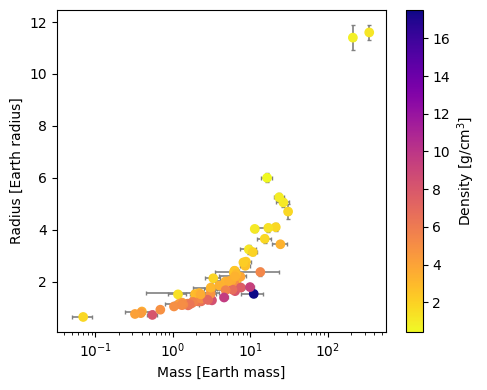

In [544]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

From Luque et al. 2022's Figure 3a, rocky, Earth-like worlds have the largest densities of the three populations. I'll choose a cut of $\rho > 0.6 \rho_{\oplus}$ as the worlds to call "Rocky worlds"

In [545]:
from astropy import constants
from astropy import units as u

In [546]:
earth_density = (constants.M_earth/(4.*np.pi/3.*(constants.R_earth)**3)).to(u.g/u.cm**3).value

In [547]:
rocky_world_ind = c > 0.6*earth_density

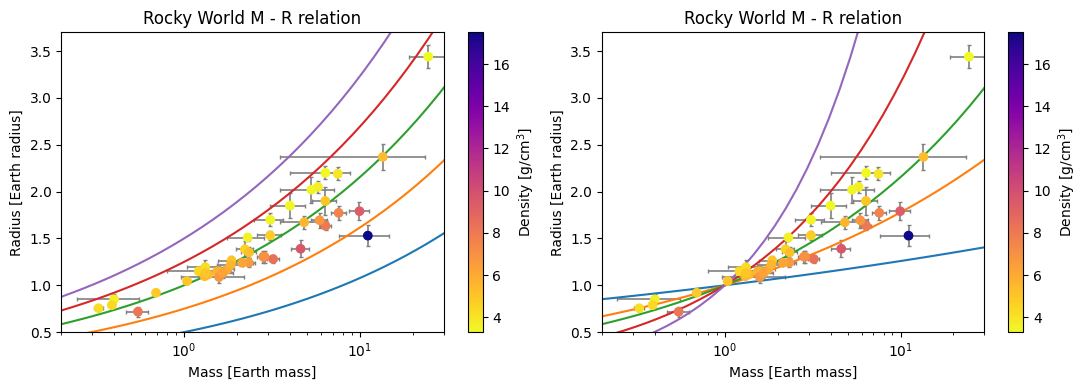

In [548]:
## Plot the mass and radius of small planets around M-dwarfs
@np.vectorize
def mock_MR_relation(M, a, b):
    return a*M**b
M_ls = 10**np.linspace(-1, 2)


plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.errorbar(M[rocky_world_ind], R[rocky_world_ind], xerr=err_M[rocky_world_ind], yerr=err_R[rocky_world_ind],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M[rocky_world_ind], R[rocky_world_ind], c=c[rocky_world_ind], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.title('Rocky World M - R relation')
gca = plt.gca()

[plt.plot(M_ls, mock_MR_relation(M_ls, a_, 1./3.)) for a_ in [0.5, 0.75, 1, 1.25, 1.5]]


# plt.xlim(gca.get_xlim())
# plt.ylim(gca.get_ylim())
plt.xlim((0.2, 30))
plt.ylim((0.5, 3.7))


plt.subplot(1,2,2)
plt.errorbar(M[rocky_world_ind], R[rocky_world_ind], xerr=err_M[rocky_world_ind], yerr=err_R[rocky_world_ind],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M[rocky_world_ind], R[rocky_world_ind], c=c[rocky_world_ind], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.title('Rocky World M - R relation')
gca = plt.gca()

[plt.plot(M_ls, mock_MR_relation(M_ls, 1, b_)) for b_ in [0.1, 0.25, 1./3., 0.5, 0.75]]

plt.xlim((0.2, 30))
plt.ylim((0.5, 3.7))

plt.show()

The left panel has the model with $b$ fixed at $1/3$ and $a \in [0.5, 0.75, 1, 1.25, 1.5]$, while the right panel has $a = 1$, $b \in[0.1, 0.25, 1/3, 0.5, 0.75]$. This is pretty reasonable at representing the data, so we can adopt this range for our uniform distribution priors on $a$ and $b$.

In [549]:
import pymc as pm

In [550]:
len(np.where(rocky_world_ind)[0])

43

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

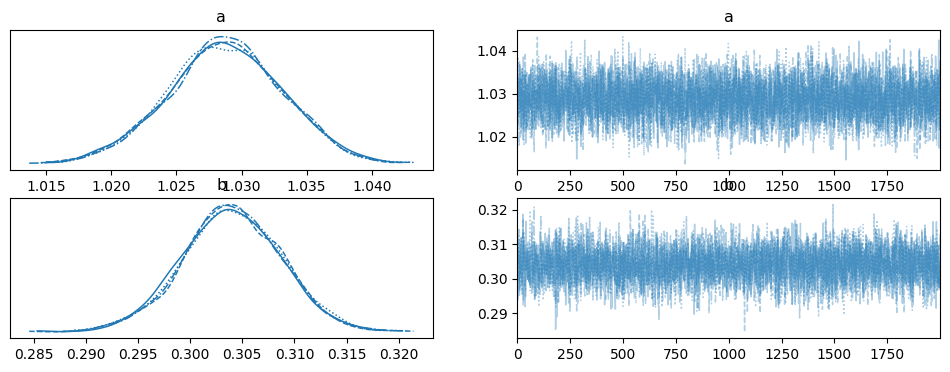

In [551]:
with pm.Model() as hierarchical_model:
    a = pm.Uniform("a", 0.5, 1.5)
    b = pm.Uniform("b", 0.1, 0.75)
    #M = pm.Normal("M", mu=np.mean(M[rocky_world_ind]), sigma=np.std(M[rocky_world_ind]))

    R_pred = a*M[rocky_world_ind].array**b
    
    #R_pred = pm.Deterministic("R_pred", a*M[rocky_world_ind]**b) #a*(M[rocky_world_ind]**b) #
    
    like = pm.Normal("likelihood", mu=R_pred, sigma=err_R[rocky_world_ind], observed=R[rocky_world_ind])
    hm = pm.sample(2000, tune=500, target_accept=0.9)
res_hm = pm.summary(hm)
res_hm
pm.plot_trace(hm)

In [552]:
np.median(hm.posterior['a'])

1.028753614762321

In [553]:
np.median(hm.posterior['b'])

0.3039639568027621

(0.5, 3.7)

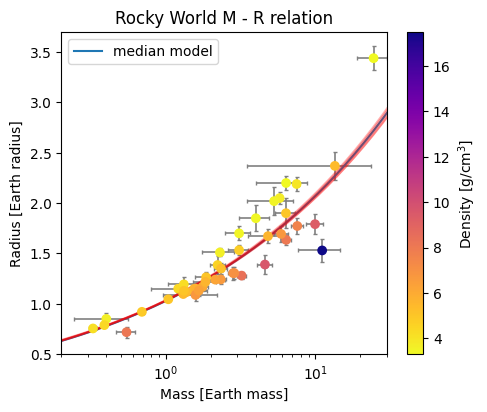

In [554]:
plt.figure(figsize=(5,4))
plt.errorbar(M[rocky_world_ind], R[rocky_world_ind], xerr=err_M[rocky_world_ind], yerr=err_R[rocky_world_ind],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M[rocky_world_ind], R[rocky_world_ind], c=c[rocky_world_ind], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.title('Rocky World M - R relation')
gca = plt.gca()

plt.plot(M_ls, mock_MR_relation(M_ls, np.median(hm.posterior['a']),
                                np.median(hm.posterior['b'])),
        label='median model')

for ind1, ind2 in list(zip(np.random.randint(4, size=5), np.random.randint(2000, size=5))):
    plt.plot(M_ls,
            mock_MR_relation(M_ls, hm.posterior['a'][ind1, ind2],
                                hm.posterior['b'][ind1, ind2]), color='r', alpha=0.3)


plt.legend()
plt.xlim((0.2, 30))
plt.ylim((0.5, 3.7))

### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution

    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
    

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

I select the Rocky + Water world sample by requiring the average density of the planet to be larger than what I call the "mixed composition density", which is the average density if the inner half radius of the planet were 90\% Earth density and the outer half radius of the planet were water ice density (91.7% that of water).

Text(0.5, 0, 'density of Rocky+Water World selected planets')

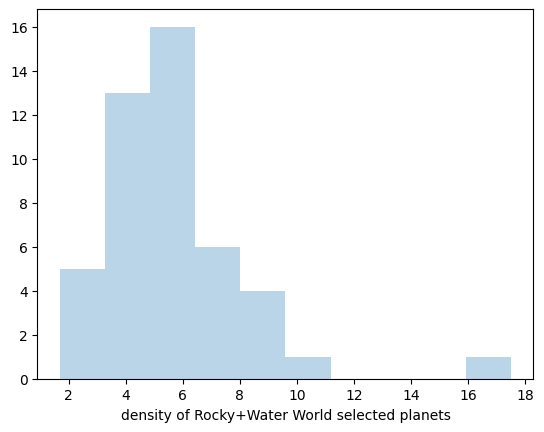

In [569]:
half_earth_density = 0.9*earth_density*(4./3.*np.pi*(R*u.R_earth.to(u.cm)/2.)**3)
half_ice_density = 0.917*(4./3.*np.pi*(R*u.R_earth.to(u.cm)**3 - (R*u.R_earth.to(u.cm)/2.)**3))
mixed_composition_mass = half_earth_density + half_ice_density
mixed_comp_density = mixed_composition_mass/(4./3.*np.pi*(R*u.R_earth.to(u.cm)**3))
plt.hist(c[c >= mixed_comp_density], alpha=0.3)
plt.xlabel('density of Rocky+Water World selected planets')

/Users/alexgreen/Library/Python/3.8/lib/python/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/alexgreen/Library/Python/3.8/lib/python/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/alexgreen/Library/Python/3.8/lib/python/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/alexgreen/Library/Python/3.8/lib/python/site-packages/arviz/stats/diagnostics.p

array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

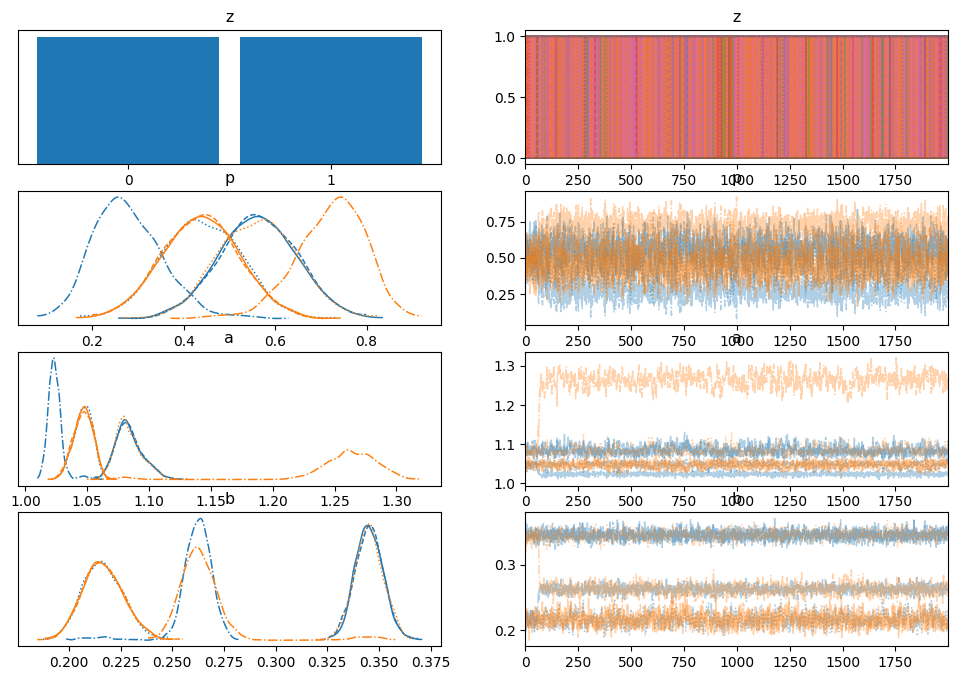

In [570]:
RockyWaterWorlds = c >= mixed_comp_density

# RockyWaterWorlds = c > (0.5*(0.3*earth_density) + 0.5*0.917)


# RockyWaterWorlds = (M <= 6.) & (R <= 2.3)

# The third population have radii larger than2.3R⊕and masses higher than 6M⊕
# .Thesearelarger than rocky or water-rich planets of thesame mass

with pm.Model() as hierarchical_model:
    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(np.where(RockyWaterWorlds)[0]))
    
    
    a = pm.Uniform("a", 0.5, 1.5, shape=2)#, transform=pm.distributions.transforms.ordered)
    b = pm.Uniform("b", 0.1, 0.75, shape=2)
    #M = pm.Normal("M", mu=np.mean(M[rocky_world_ind]), sigma=np.std(M[rocky_world_ind]))

    R_pred = z*(a[0]*M[RockyWaterWorlds].array**b[0]) + (1-z)*(a[1]*M[RockyWaterWorlds].array**b[1])
    
    #R_pred = pm.Deterministic("R_pred", a*M[rocky_world_ind]**b) #a*(M[rocky_world_ind]**b) #
    
    like = pm.Normal("likelihood", mu=R_pred, sigma=err_R[RockyWaterWorlds], observed=R[RockyWaterWorlds])
    hm = pm.sample(2000, tune=500, target_accept=0.9)
res_hm = pm.summary(hm)
res_hm
pm.plot_trace(hm)

In [571]:
edgecolorarr = np.array(['C'+str((~np.median(hm.posterior['z'][:,:,p_num]).astype(bool)).astype(int))
                for p_num in range(len(np.where(RockyWaterWorlds)[0]))])

(0.5, 3.7)

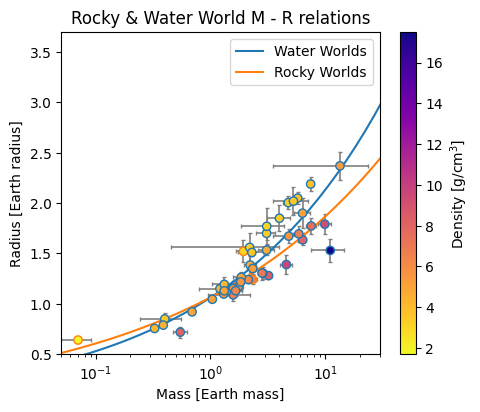

In [579]:
M_ls = 10**np.linspace(-2, 2, 50)

plt.figure(figsize=(5,4))
plt.errorbar(M[RockyWaterWorlds], R[RockyWaterWorlds], xerr=err_M[RockyWaterWorlds], yerr=err_R[RockyWaterWorlds],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M[RockyWaterWorlds], R[RockyWaterWorlds], c=c[RockyWaterWorlds], zorder=100, cmap='plasma_r',
           edgecolor=edgecolorarr)
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.title('Rocky & Water World M - R relations')
gca = plt.gca()

plt.plot(M_ls, mock_MR_relation(M_ls, np.median(hm.posterior['a'][:,:,0]),
                                np.median(hm.posterior['b'][:,:,0])),
        label='Water Worlds')

plt.plot(M_ls, mock_MR_relation(M_ls, np.median(hm.posterior['a'][:,:,1]),
                                np.median(hm.posterior['b'][:,:,1])),
        label='Rocky Worlds')

plt.legend()
plt.xlim((0.05, 30))
plt.ylim((0.5, 3.7))

Make some draws for each type:

(0.5, 3.7)

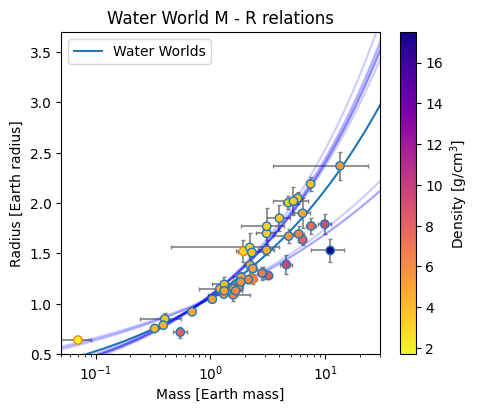

In [582]:
M_ls = 10**np.linspace(-2, 2, 50)

plt.figure(figsize=(5,4))
plt.errorbar(M[RockyWaterWorlds], R[RockyWaterWorlds], xerr=err_M[RockyWaterWorlds], yerr=err_R[RockyWaterWorlds],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M[RockyWaterWorlds], R[RockyWaterWorlds], c=c[RockyWaterWorlds], zorder=100, cmap='plasma_r',
           edgecolor=edgecolorarr)
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.title('Water World M - R relations')
gca = plt.gca()

plt.plot(M_ls, mock_MR_relation(M_ls, np.median(hm.posterior['a'][:,:,0]),
                                np.median(hm.posterior['b'][:,:,0])),
        label='Water Worlds')

for ind1, ind2 in list(zip(np.random.randint(4, size=10), np.random.randint(2000, size=10))):
    

    plt.plot(M_ls, mock_MR_relation(M_ls, hm.posterior['a'][ind1,
                                                           ind2,
                                                           0],
                                   hm.posterior['b'][ind1,
                                                    ind2,
                                                           0]), c='blue', alpha=0.2)


# for ind1, ind2 in list(zip(np.random.randint(4, size=5), np.random.randint(2000, size=5))):
#     plt.plot(M_ls,
#             mock_MR_relation(M_ls, hm.posterior['a'][ind1, ind2],
#                                 hm.posterior['b'][ind1, ind2]), color='r', alpha=0.3)


plt.legend()
plt.xlim((0.05, 30))
plt.ylim((0.5, 3.7))

(0.5, 3.7)

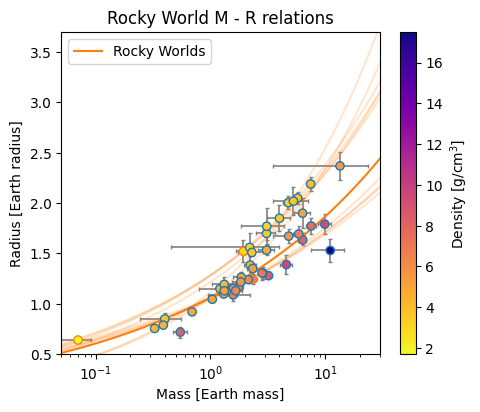

In [583]:
M_ls = 10**np.linspace(-2, 2, 50)

plt.figure(figsize=(5,4))
plt.errorbar(M[RockyWaterWorlds], R[RockyWaterWorlds], xerr=err_M[RockyWaterWorlds], yerr=err_R[RockyWaterWorlds],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M[RockyWaterWorlds], R[RockyWaterWorlds], c=c[RockyWaterWorlds], zorder=100, cmap='plasma_r',
           edgecolor=edgecolorarr)
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.title('Rocky World M - R relations')
gca = plt.gca()

plt.plot(M_ls, mock_MR_relation(M_ls, np.median(hm.posterior['a'][:,:,1]),
                                np.median(hm.posterior['b'][:,:,1])),
        label='Rocky Worlds', color='C1')

for ind1, ind2 in list(zip(np.random.randint(4, size=10), np.random.randint(2000, size=10))):
    

    plt.plot(M_ls, mock_MR_relation(M_ls, hm.posterior['a'][ind1,
                                                           ind2,
                                                           1],
                                   hm.posterior['b'][ind1,
                                                    ind2,
                                                           1]), c='C1', alpha=0.2)


# for ind1, ind2 in list(zip(np.random.randint(4, size=5), np.random.randint(2000, size=5))):
#     plt.plot(M_ls,
#             mock_MR_relation(M_ls, hm.posterior['a'][ind1, ind2],
#                                 hm.posterior['b'][ind1, ind2]), color='r', alpha=0.3)


plt.legend()
plt.xlim((0.05, 30))
plt.ylim((0.5, 3.7))

### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 